# Dependencies and Definitions

In [1]:
# Load libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas import read_csv, set_option
from pandas.plotting import scatter_matrix
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import datetime
from sklearn.cluster import OPTICS
import pandas_datareader as dr

#Import Model Packages 
from sklearn.cluster import KMeans, AgglomerativeClustering,AffinityPropagation, DBSCAN
from scipy.cluster.hierarchy import fcluster
from scipy.cluster.hierarchy import dendrogram, linkage, cophenet
from scipy.spatial.distance import pdist
from sklearn.metrics import adjusted_mutual_info_score
from sklearn import cluster, covariance, manifold


#Other Helper Packages and functions
import matplotlib.ticker as ticker
from itertools import cycle
import statsmodels.api as sm
import yfinance as yf

In [2]:
def download_stocks(tickers,start='2014-01-01',end='2018-01-01'):
    return yf.download(tickers, start = start, end = end)

def remove_null(df, cutoff = .99):
    df = df.dropna(axis=1)
    df = df.dropna(thresh=int(df.shape[1]*cutoff))
    return df

def winsorize(df,q=.025):
    clipped = df.clip(lower=df.quantile(q=q),
                   upper=df.quantile(q=1-q),
                   axis=1)
    return clipped

def df_scaler(df):
    scaler = StandardScaler().fit(df)
    return scaler

def train_test_split(df,percentage = .8):

    train_size = int(len(df)*percentage)
    train_set = df[:train_size]
    test_set = df[train_size:]

    return train_set, test_set

def normalize_data(df_train,df_test):
    scaler = StandardScaler().fit(df_train)

    train = pd.DataFrame(scaler.transform(df_train),
                         columns = df_train.columns,
                         index = df_train.index)

    test = pd.DataFrame(scaler.transform(df_test),
                        columns = df_test.columns,
                        index = df_test.index)

    return train, test


def get_distance_matrix(corr):
    """Compute distance matrix from correlation;
    0 <= d[i,j] <= 1"""
    return np.sqrt((1 - corr) / 2)

def quasi_diagonalize(link):
    """sort clustered assets by distance"""
    link = link.astype(int)
    sort_idx = pd.Series([link[-1, 0], link[-1, 1]])
    num_items = link[-1, 3]  # idx of original items
    while sort_idx.max() >= num_items:
        sort_idx.index = list(range(0, sort_idx.shape[0] * 2, 2))  # make space
        df0 = sort_idx[sort_idx >= num_items]  # find clusters
        i = df0.index
        j = df0.values - num_items
        sort_idx[i] = link[j, 0]  # item 1
        df0 = pd.Series(link[j, 1], index=i + 1)
        #sort_idx = sort_idx.append(df0)  # item 2
        sort_idx = pd.concat([sort_idx,df0])
        sort_idx = sort_idx.sort_index()  # re-sort
        sort_idx.index = list(range(sort_idx.shape[0]))  # re-index
    return sort_idx.tolist()

def clustered_corr_plot(df,include_ticks = True):
    corr = df.corr()

    distance_matrix = get_distance_matrix(corr)
    linkage_matrix = linkage(squareform(distance_matrix), 'single')
    sorted_idx = quasi_diagonalize(linkage_matrix)

    clustergrid = sns.clustermap(distance_matrix,
                             method='single',
                             row_linkage=linkage_matrix,
                             col_linkage=linkage_matrix,
                             center=0);
    plt.close()

    sorted_idx = clustergrid.dendrogram_row.reordered_ind
    sorted_tickers = corr.index[sorted_idx].tolist()
    fig, ax = plt.subplots(figsize=(18, 8))

    #sns.heatmap(corr, center = 0, ax=axes[0])
    #axes[0].set_title('Correlation Matrix')
    #fig.tight_layout()

    clustered_assets = corr.loc[sorted_tickers, sorted_tickers]  # reorder

    sns.heatmap(clustered_assets, center = 0, ax=ax)
    ax.set_title('Clustered Correlation')
    if not include_ticks:
        ax.xaxis.set_tick_params(labelbottom=False)
        ax.yaxis.set_tick_params(labelleft=False)
        ax.set_xticks([])
        ax.set_yticks([])

    fig.tight_layout();

    return fig

# Download Data

In [14]:
SP_stocks[0]

,Symbol,Security,GICS Sector,GICS Sub-Industry,Headquarters Location,Date added,CIK,Founded
0,MMM,3M,Industrials,Industrial Conglomerates,"Saint Paul, Minnesota",1957-03-04,66740,1902
1,AOS,A. O. Smith,Industrials,Building Products,"Milwaukee, Wisconsin",2017-07-26,91142,1916
2,ABT,Abbott,Health Care,Health Care Equipment,"North Chicago, Illinois",1957-03-04,1800,1888
3,ABBV,AbbVie,Health Care,Pharmaceuticals,"North Chicago, Illinois",2012-12-31,1551152,2013 (1888)
4,ACN,Accenture,Information Technology,IT Consulting & Other Services,"Dublin, Ireland",2011-07-06,1467373,1989
...,...,...,...,...,...,...,...,...
498,YUM,Yum! Brands,Consumer Discretionary,Restaurants,"Louisville, Kentucky",1997-10-06,1041061,1997
499,ZBRA,Zebra Technologies,Information Technology,Electronic Equipment & Instruments,"Lincolnshire, Illinois",2019-12-23,877212,1969
500,ZBH,Zimmer Biomet,Health Care,Health Care Equipment,"Warsaw, Indiana",2001-08-07,1136869,1927
501,ZION,Zions Bancorporation,Financials,Regional Banks,"Salt Lake City, Utah",2001-06-22,109380,1873


In [3]:
# load dataset
#scraping wikipedia to fetch S&P 500 and DJI stock list
snp500url = "https://en.wikipedia.org/wiki/List_of_S%26P_500_companies"
SP_stocks = pd.read_html(snp500url)
SP_tickers = SP_stocks[0]['Symbol'].to_list()

In [4]:
SP_data = download_stocks(SP_tickers,start='2010-01-01')['Adj Close'].dropna(axis=1)
SP_data.index = pd.to_datetime(SP_data.index)

total_time = SP_data.shape[0]
train_end = int(total_time*.6)
val_end = train_end + int(total_time*.2)

df = {}

df['train'] = SP_data[:train_end]
df['valid'] = SP_data[train_end:val_end]
df['test'] = SP_data[val_end:]

df_ret = {}
for key in df:
    df_ret[key] = df[key].pct_change().dropna()

[*********************100%***********************]  503 of 503 completed


14 Failed downloads:
['CTVA', 'GEHC', 'OTIS', 'CDAY', 'VICI', 'CEG', 'CARR', 'DOW', 'FOX', 'OGN', 'FOXA', 'MRNA']: Exception("%ticker%: Data doesn't exist for startDate = 1262322000, endDate = 1514782800")
['BF.B']: Exception('%ticker%: No price data found, symbol may be delisted (1d 2010-01-01 -> 2018-01-01)')
['BRK.B']: Exception('%ticker%: No timezone found, symbol may be delisted')


In [5]:
sectors = SP_stocks[0]['GICS Sector'].unique()

In [8]:
df_sectors = {}

for key in df:
    df_sectors[key] = {}
    
    for sector in sectors:
        ticker_sector = SP_stocks[0][SP_stocks[0]['GICS Sector']==sector]['Symbol'].to_list()
        ticker_sector = list(set(ticker_sector) & set(df_ret[key].columns))
        df_sectors[key][sector] = df_ret[key].loc[:,ticker_sector]

In [11]:
df_aggs = {}

for key in df_sectors:
    df_aggs[key] = {}
    for sector in sectors:
        df_aggs[key][sector] = df_sectors[key][sector].mean()
        df_aggs[key][sector] = pd.DataFrame(df_aggs[key][sector])
        df_aggs[key][sector].columns = ['Returns']
        df_aggs[key][sector]['Volatility'] =  df_sectors[key][sector].std()
        df_aggs[key][sector]['Skew'] = df_sectors[key][sector].skew()
        df_aggs[key][sector]['Kurtosis'] = df_sectors[key][sector].kurtosis()

In [74]:
from sklearn.preprocessing import StandardScaler
rescaledDataset = {}

for key in df_aggs:
    for sector in sectors:
        scaler = StandardScaler().fit(ret_sect[sector])
        rescaledDataset[sector] = pd.DataFrame(scaler.fit_transform(df_aggs[key][sector]),
                                       columns = ret_sect[sector].columns,
                                       index = ret_sect[sector].index)
        # summarize transformed data
rescaledDataset[sector].head(2)

,Returns,Volatility,Skew,Kurtosis
PXD,0.077356,0.197174,-0.872330,-0.388043
CTRA,-0.615764,0.209856,0.003512,-0.301803


# Clustering

## Features = [Mean, Volatility, Skew, Kurtosis]

### K-means

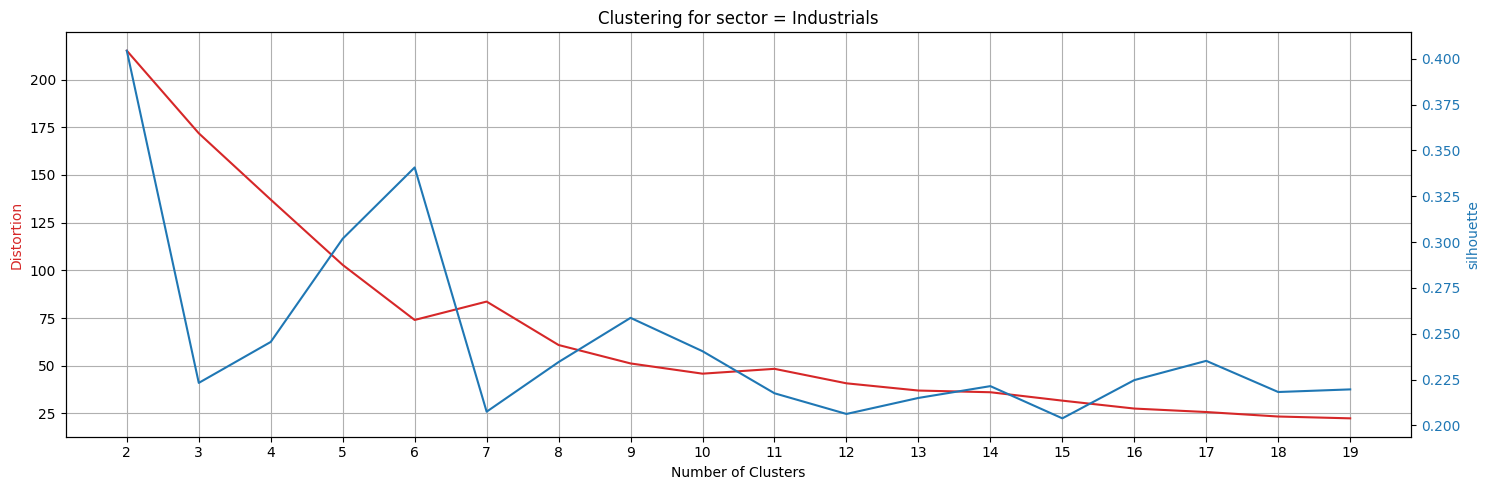

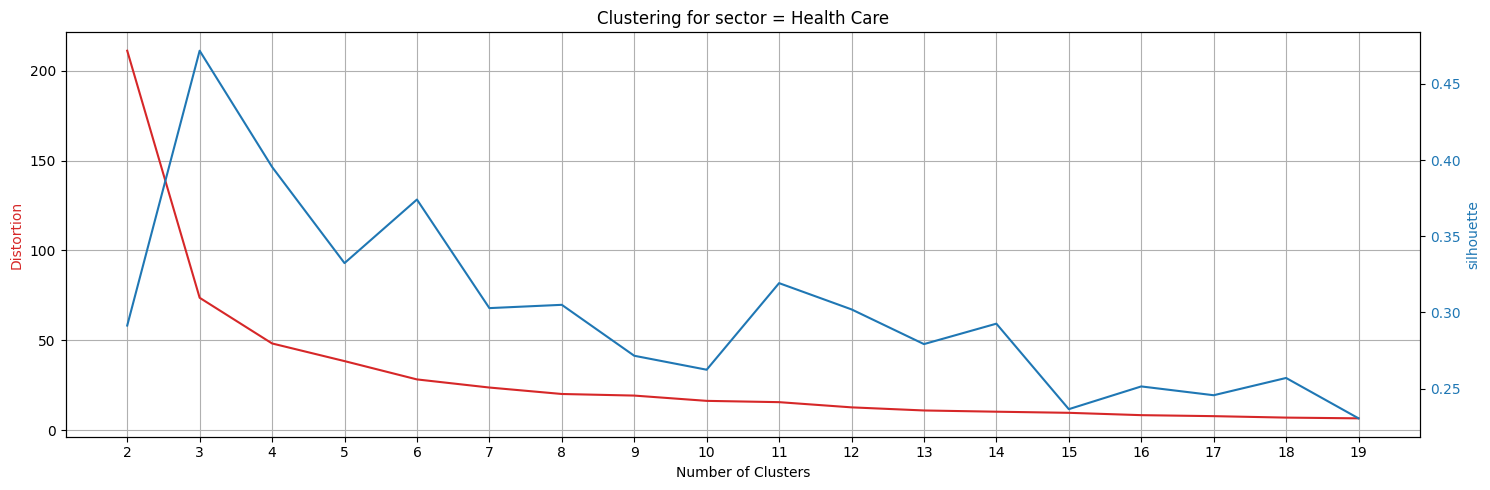

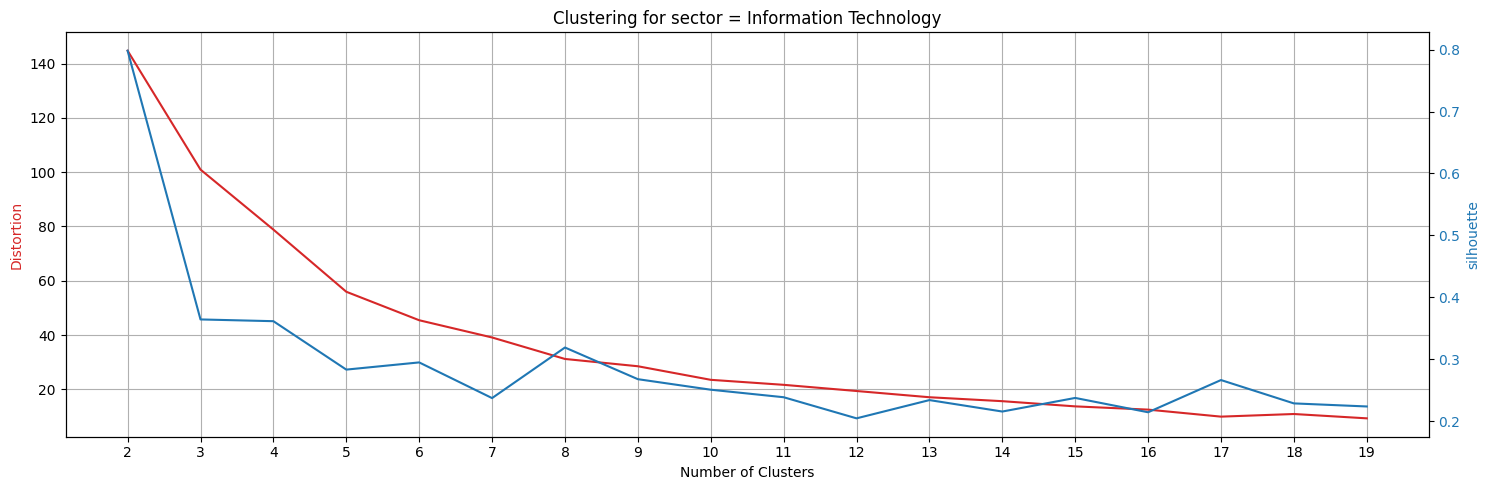

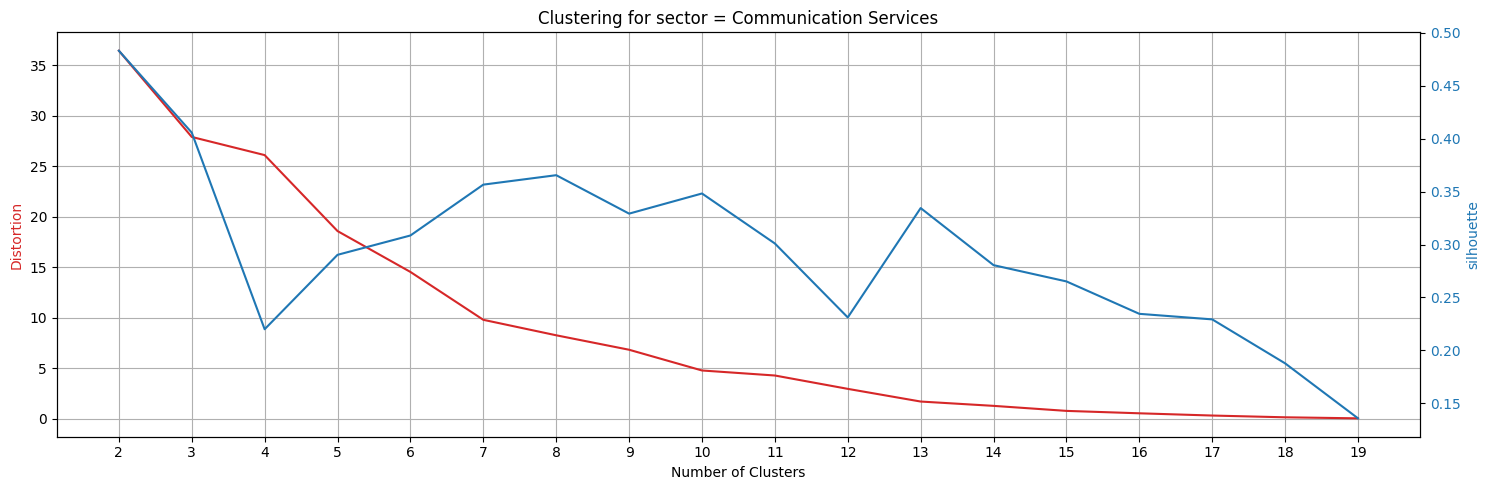

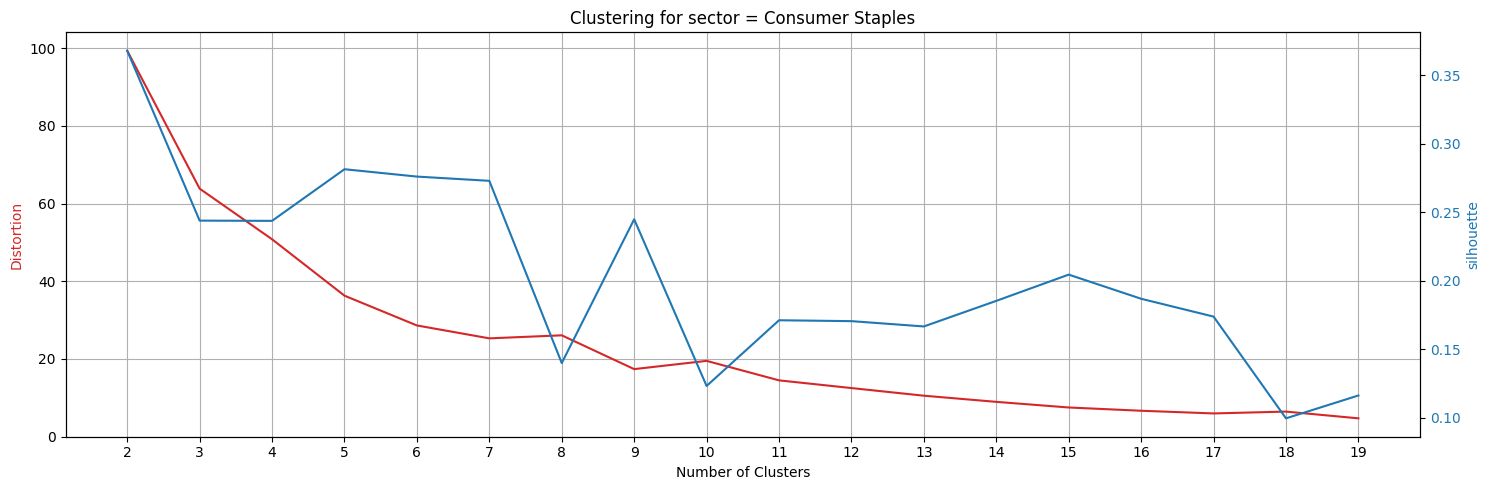

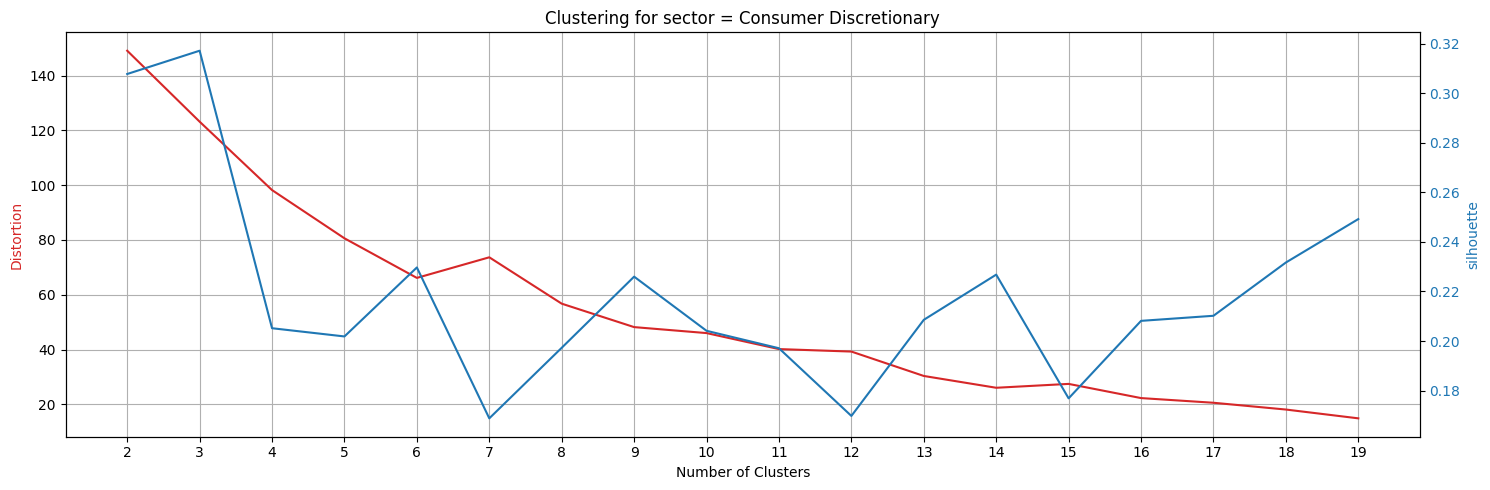

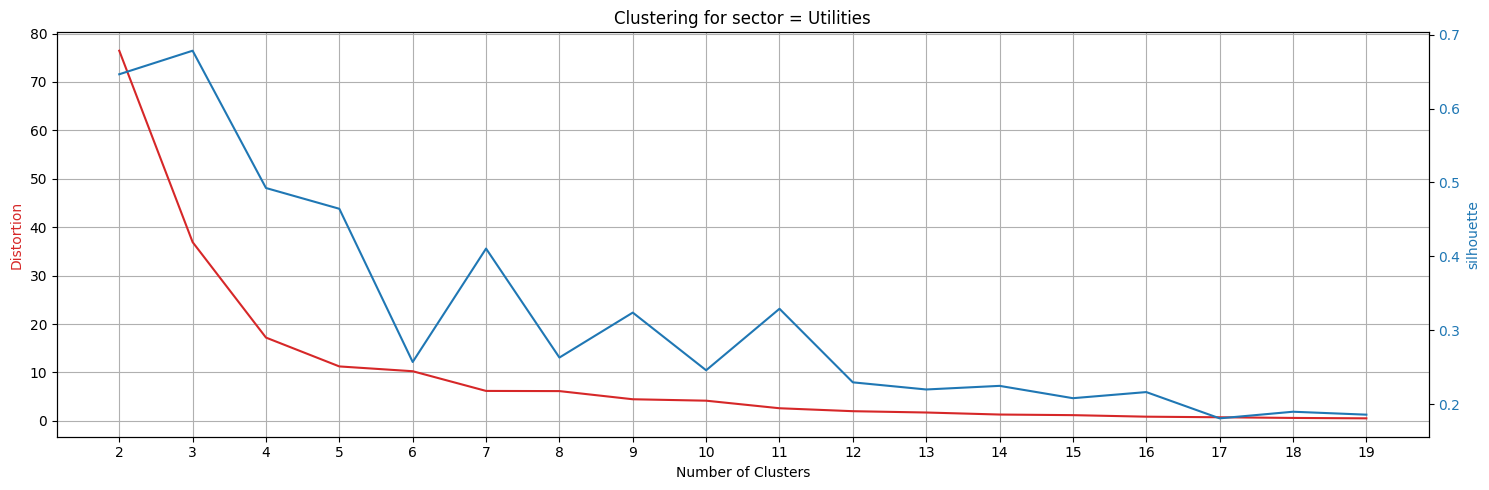

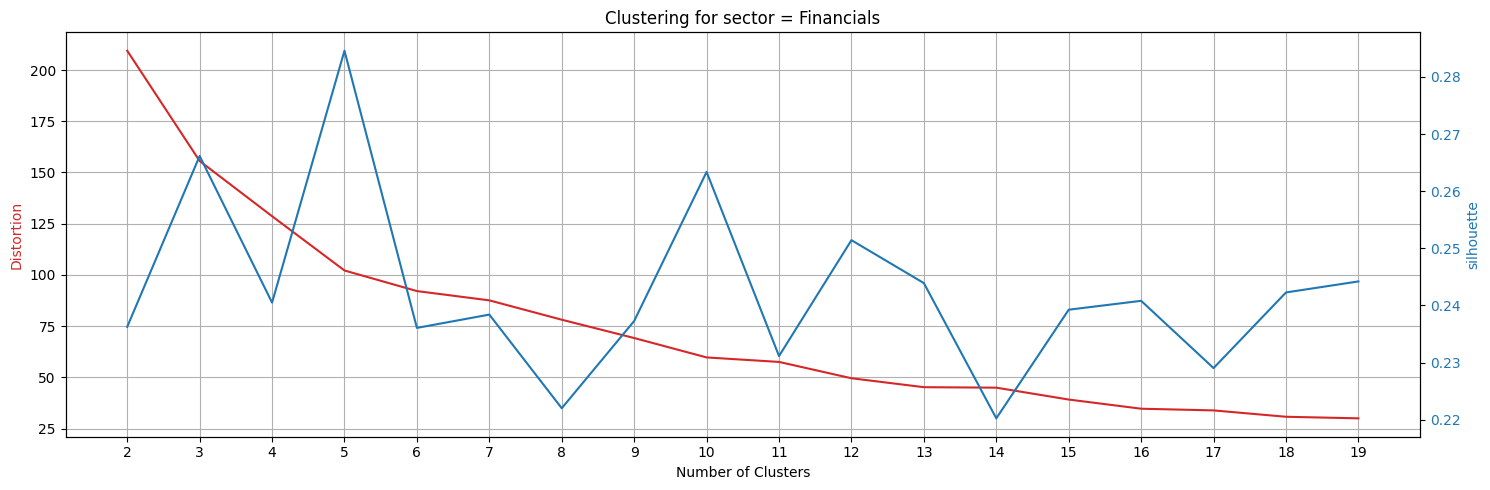

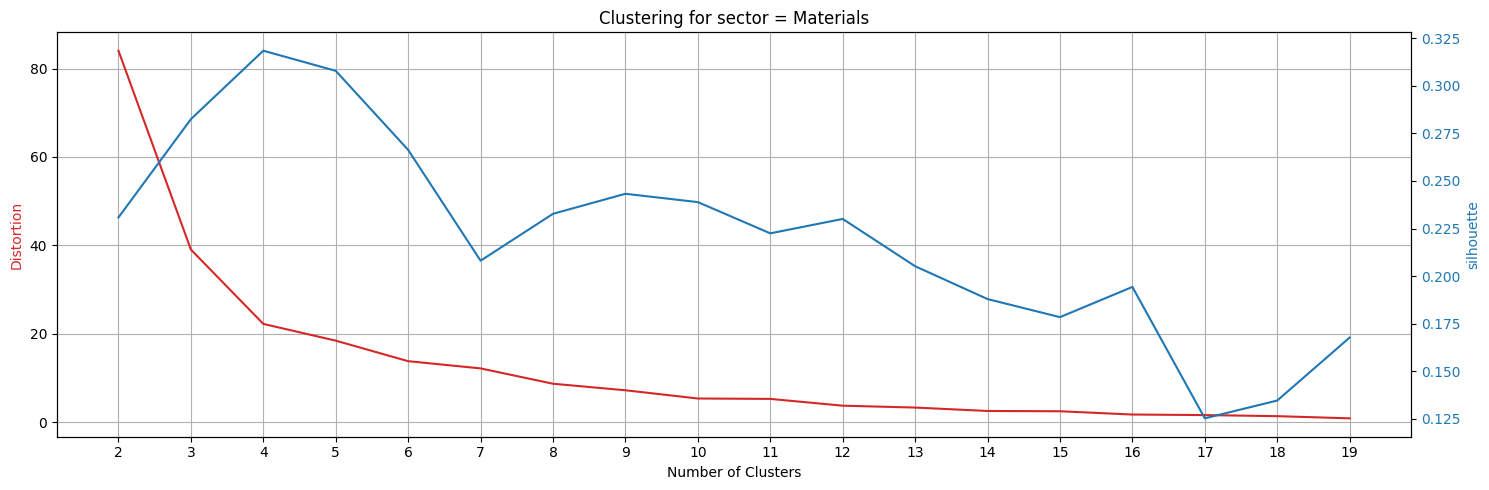

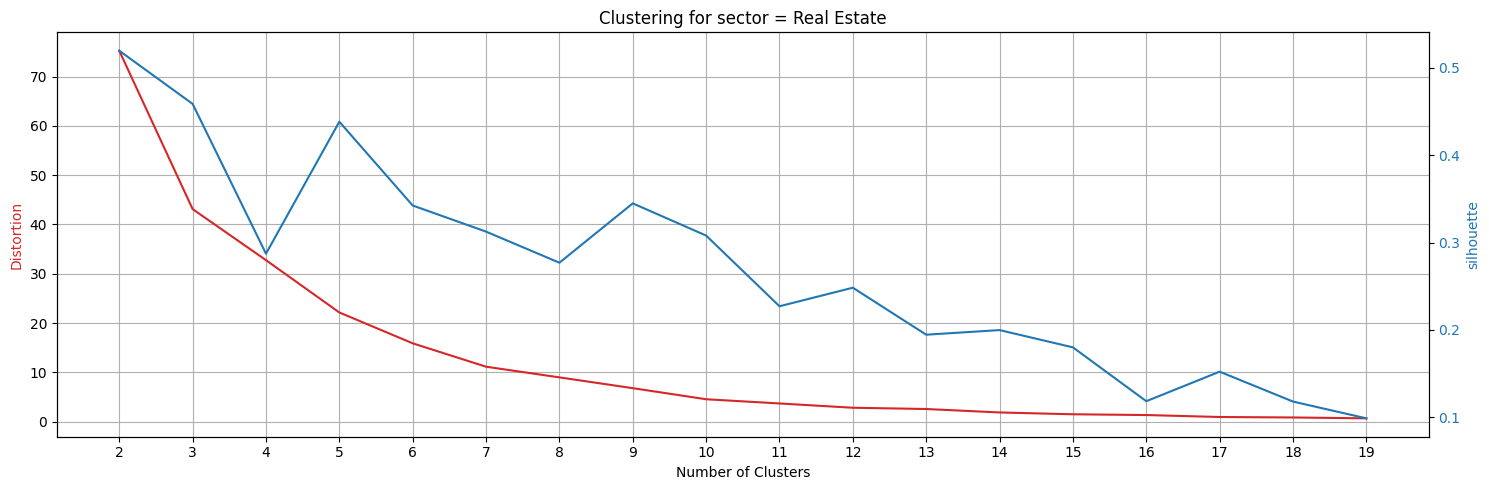

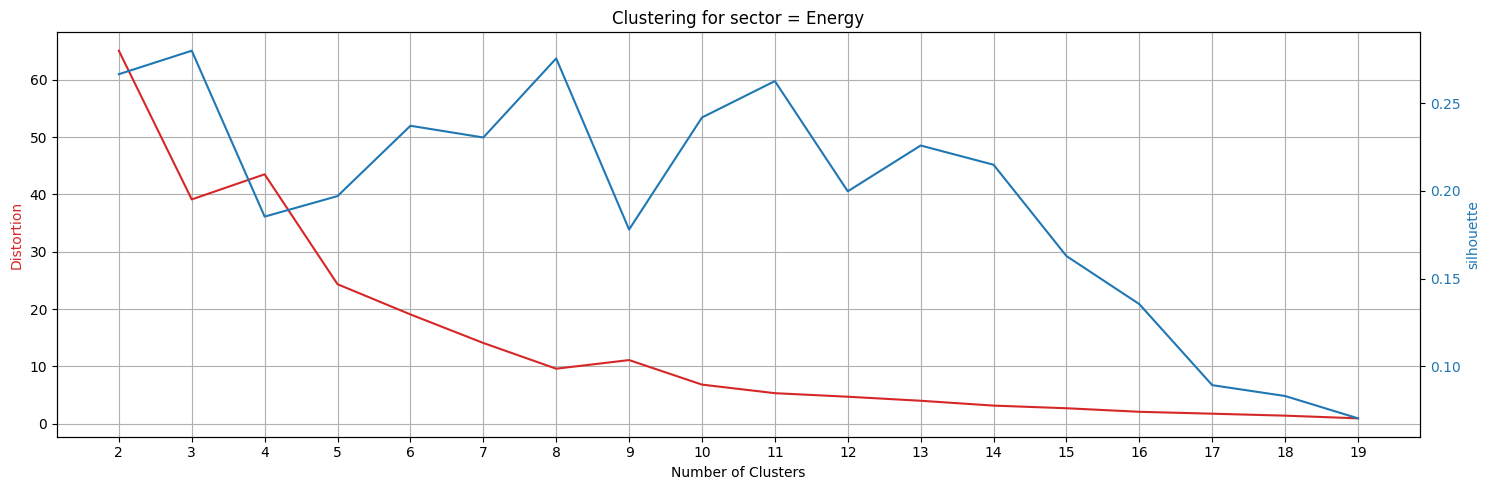

In [111]:
for sector in sectors:
    
    fig, ax1 = plt.subplots(figsize=(15, 5))
    #fig = plt.figure(figsize=(15, 5))
    
    color = 'tab:red'
    ax1.set_xlabel('Number of Clusters')
    ax1.set_ylabel('Distortion',color=color)
    plt.grid(True)
    plt.title(f'Clustering for sector = {sector}')
    distorsions = []
    max_loop=20
    silhouette_score = []
    for k in range(2, max_loop):
        kmeans = KMeans(n_clusters=k,n_init='auto')
        kmeans.fit(rescaledDataset[sector])
        distorsions.append(kmeans.inertia_)  
        silhouette_score.append(metrics.silhouette_score(rescaledDataset[sector],
                                                         kmeans.labels_,
                                                         random_state=10))
    ax1.plot(range(2, max_loop), distorsions,color=color)
    ax2 = ax1.twinx()
    
    color='tab:blue'
    ax2.set_ylabel('silhouette',color=color)
    ax2.plot(range(2, max_loop), silhouette_score,color=color)
    ax2.tick_params(axis='y',labelcolor=color)
    
    fig.tight_layout()
    #plt.xticks(ticks=np.arange(2, max_loop))
    plt.xticks([i for i in range(2, max_loop)], rotation=75)
    
    #plt.grid(visible=True, which='both', axis='both');
    
    plt.show()


In [178]:
num_clusters_kmeans = [6,3,5,7,5,6,4,5,4,5,6]

In [113]:
centroids = k_means.cluster_centers_
fig = plt.figure(figsize=(16,10))
ax = fig.add_subplot(111)
scatter = ax.scatter(X.iloc[:,0],X.iloc[:,1], c = k_means.labels_, cmap ="rainbow", label = X.index)
ax.set_title('k-Means results')
ax.set_xlabel('Mean Return')
ax.set_ylabel('Volatility')
plt.colorbar(scatter)

plt.plot(centroids[:,0],centroids[:,1],'sg',markersize=11)

11

### Hierarchical

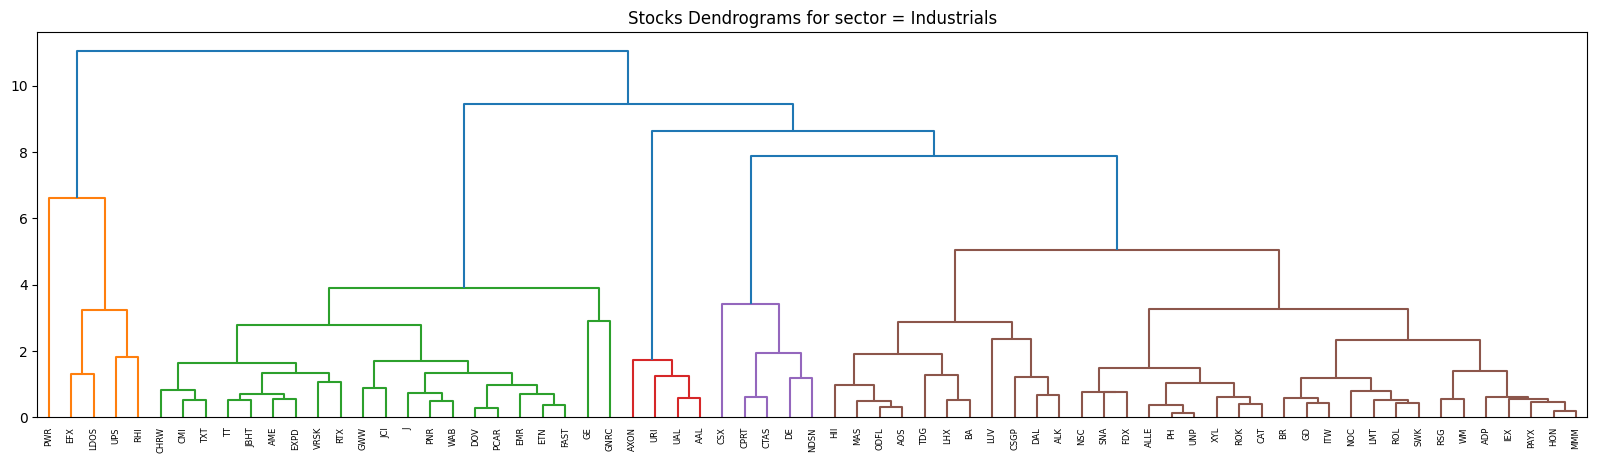

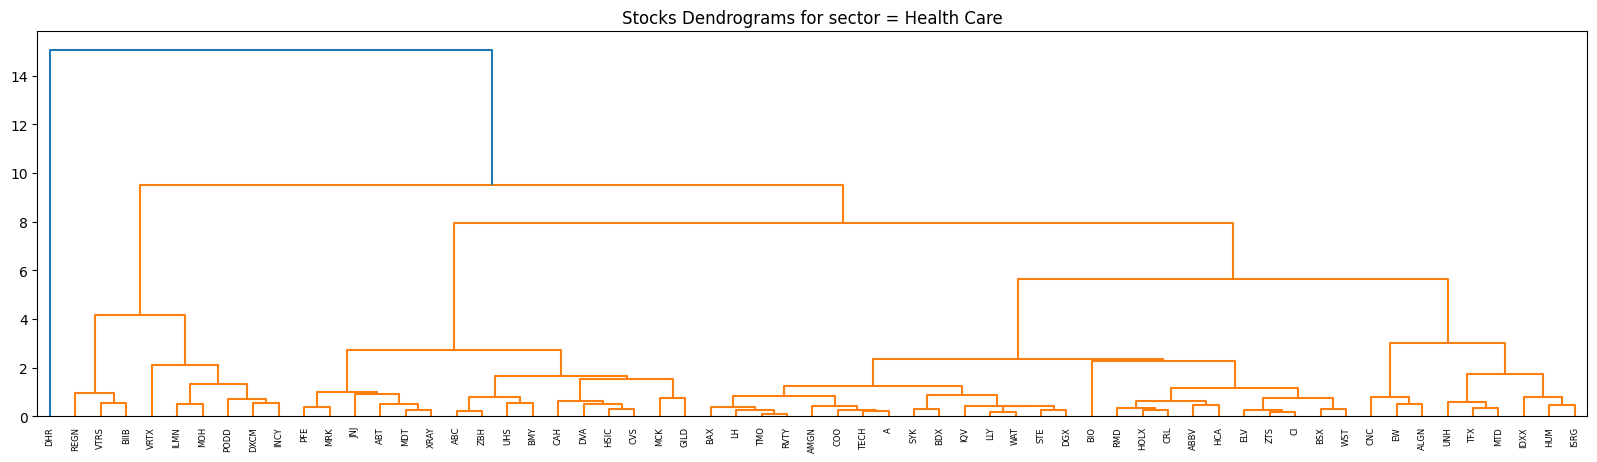

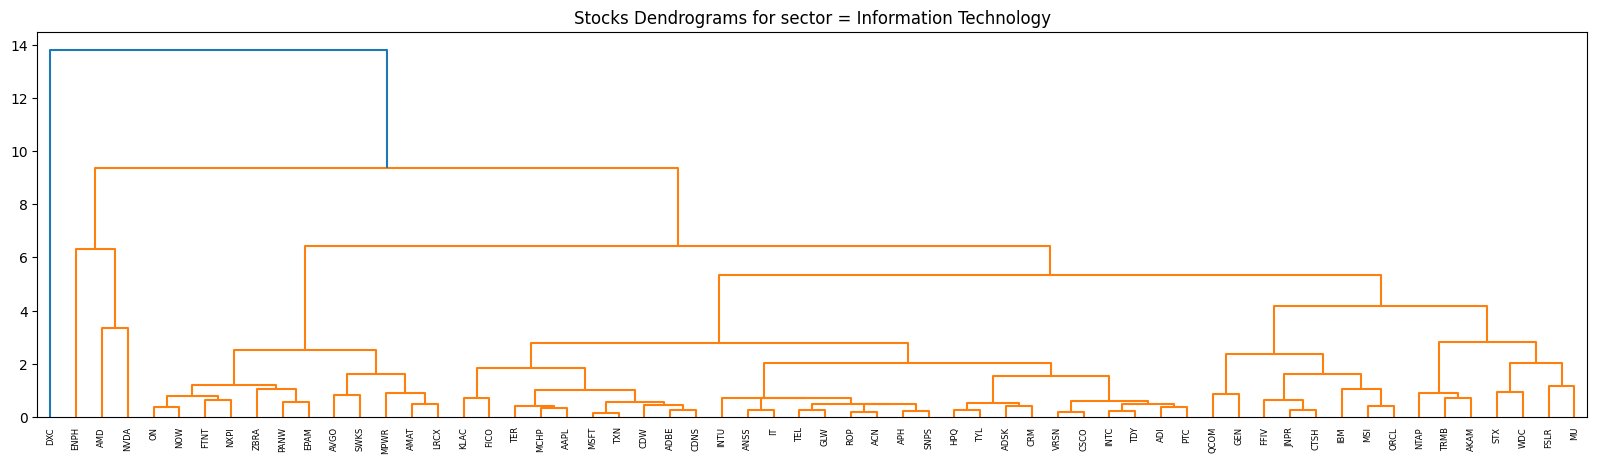

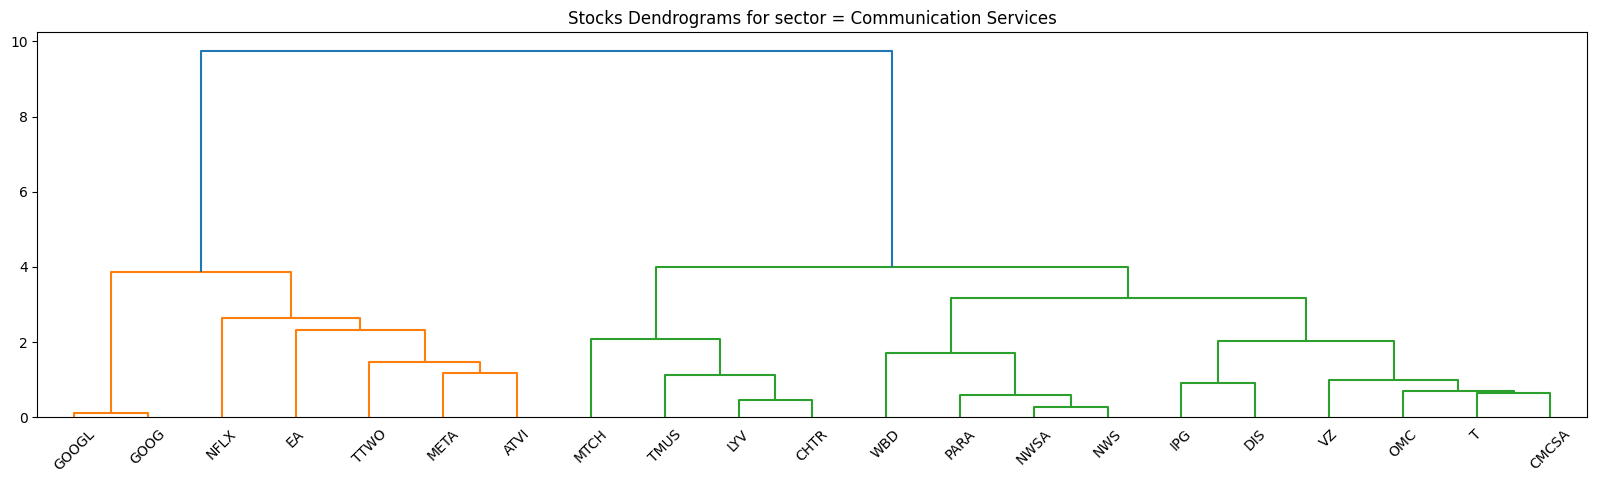

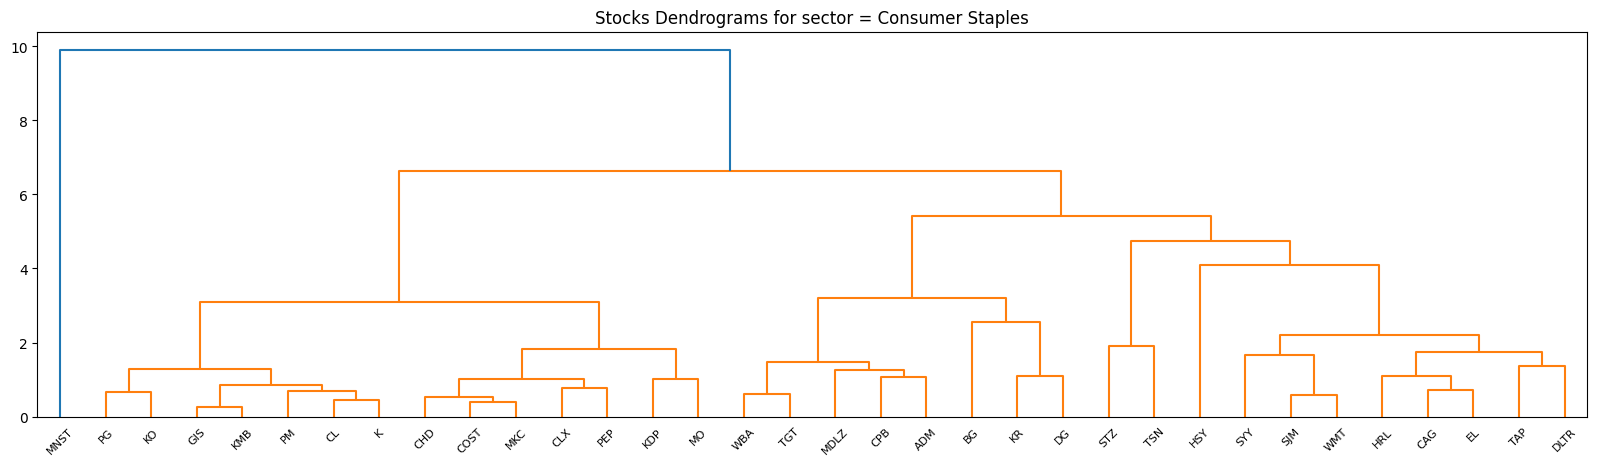

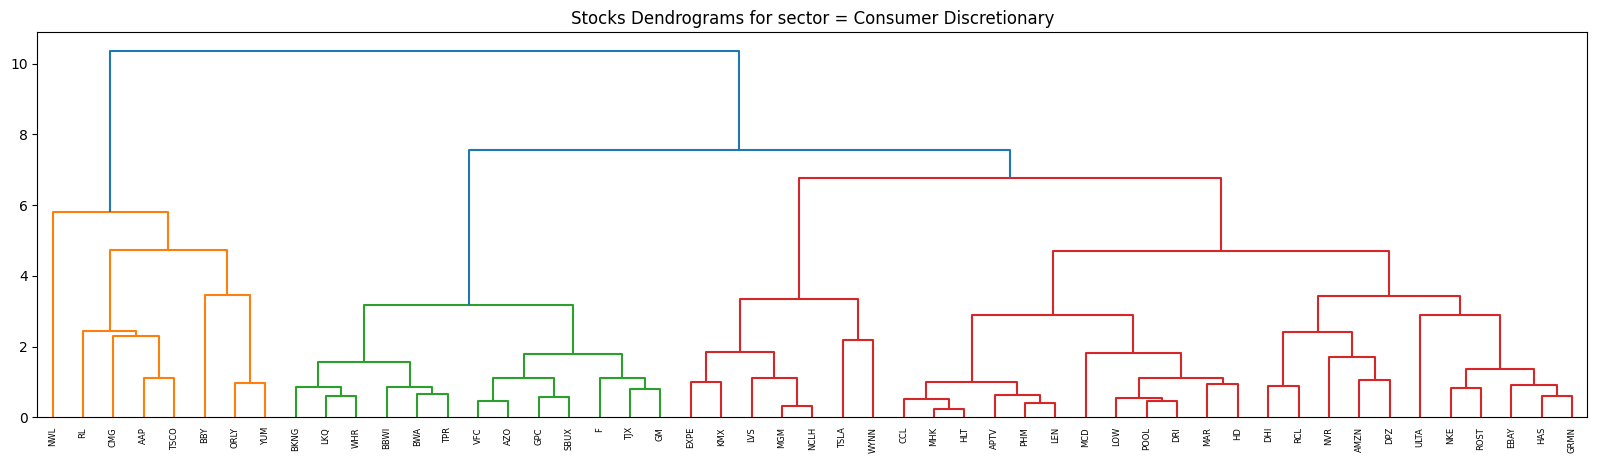

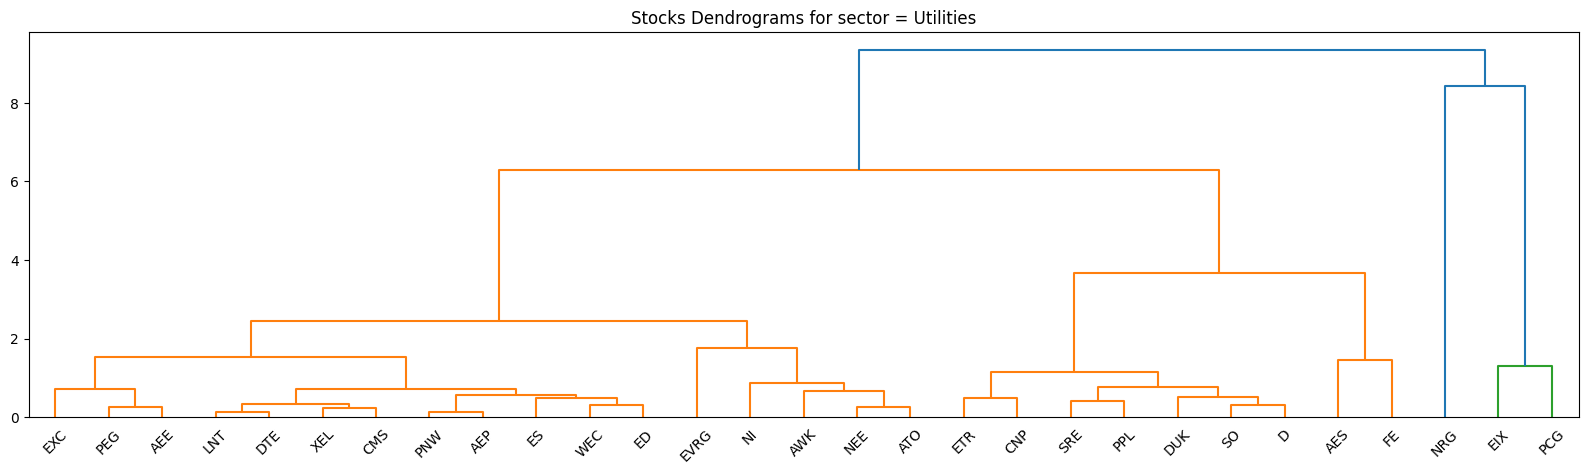

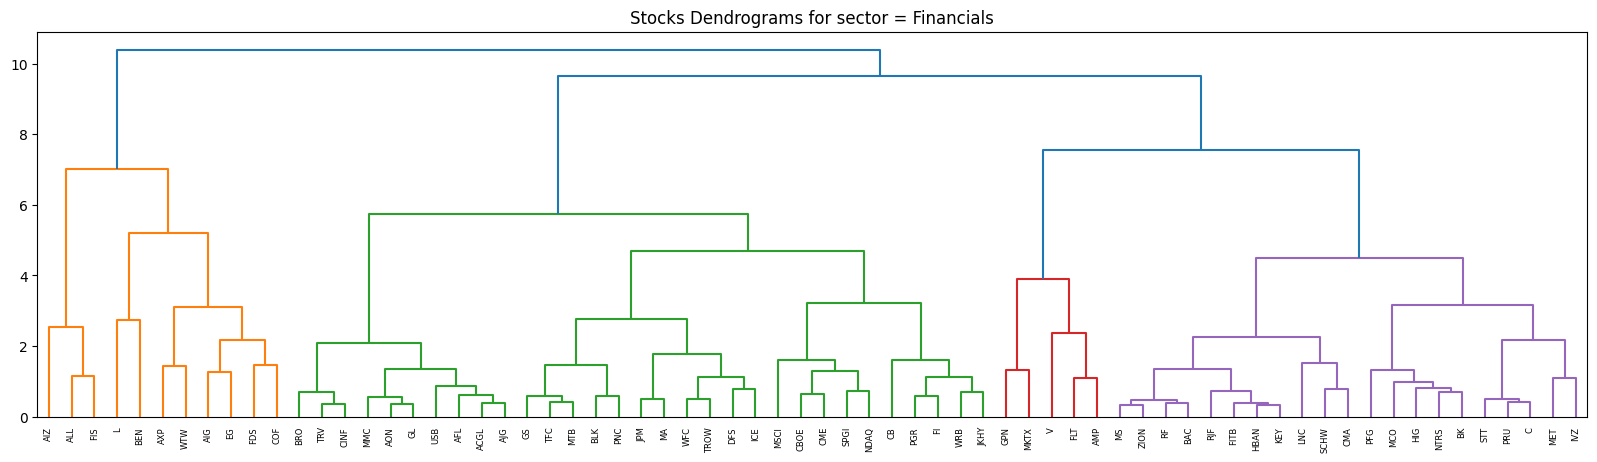

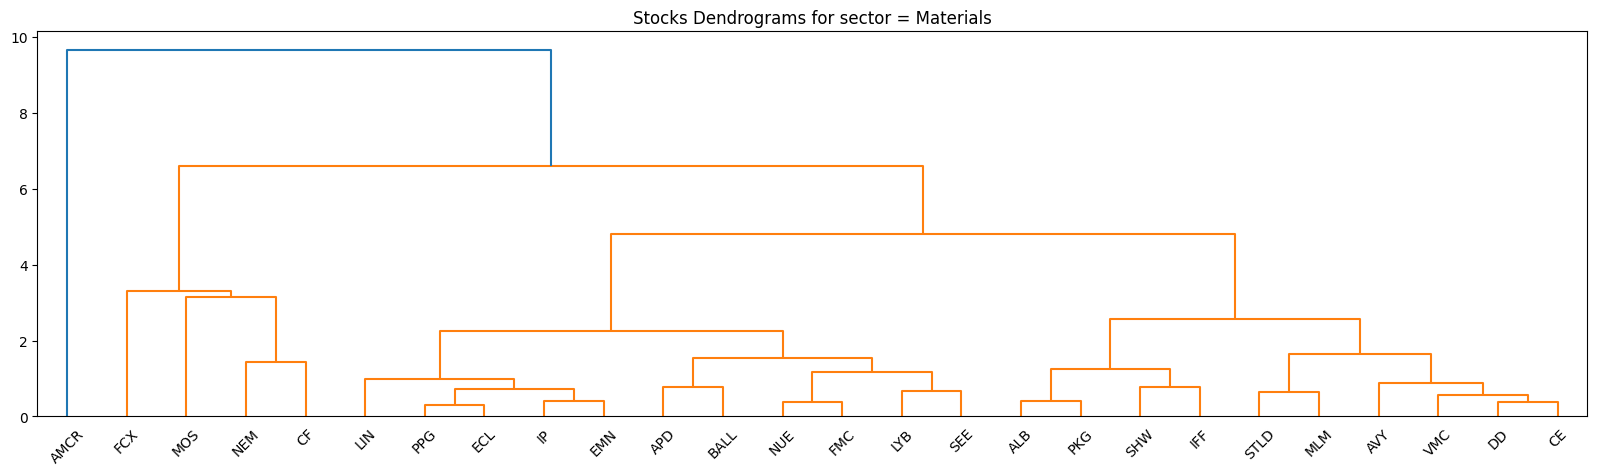

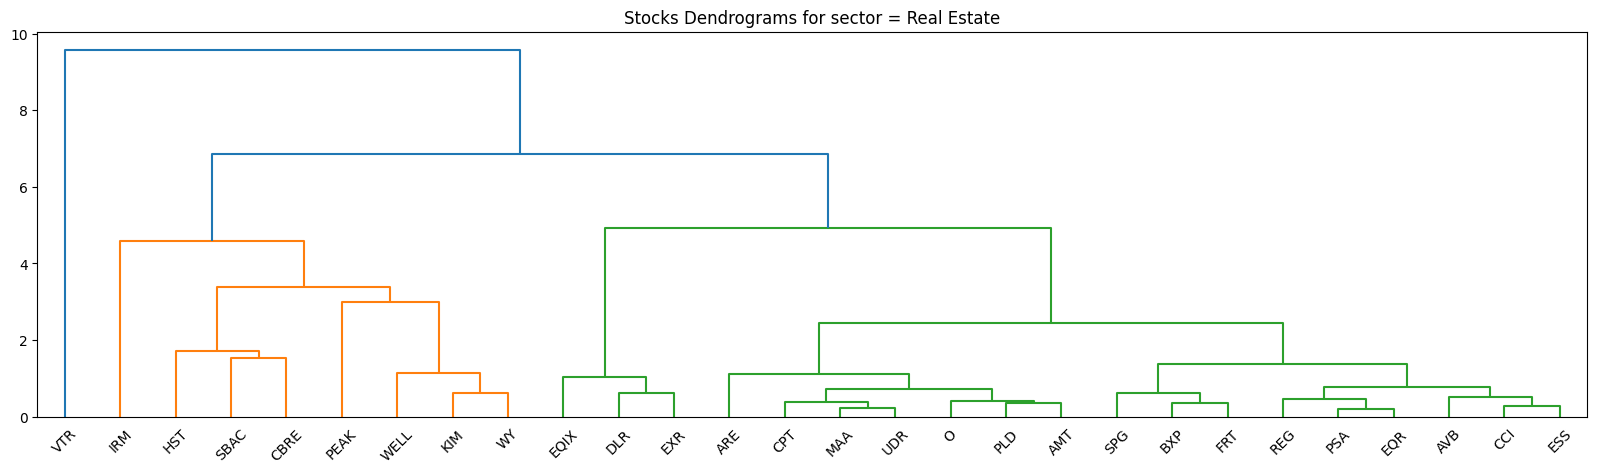

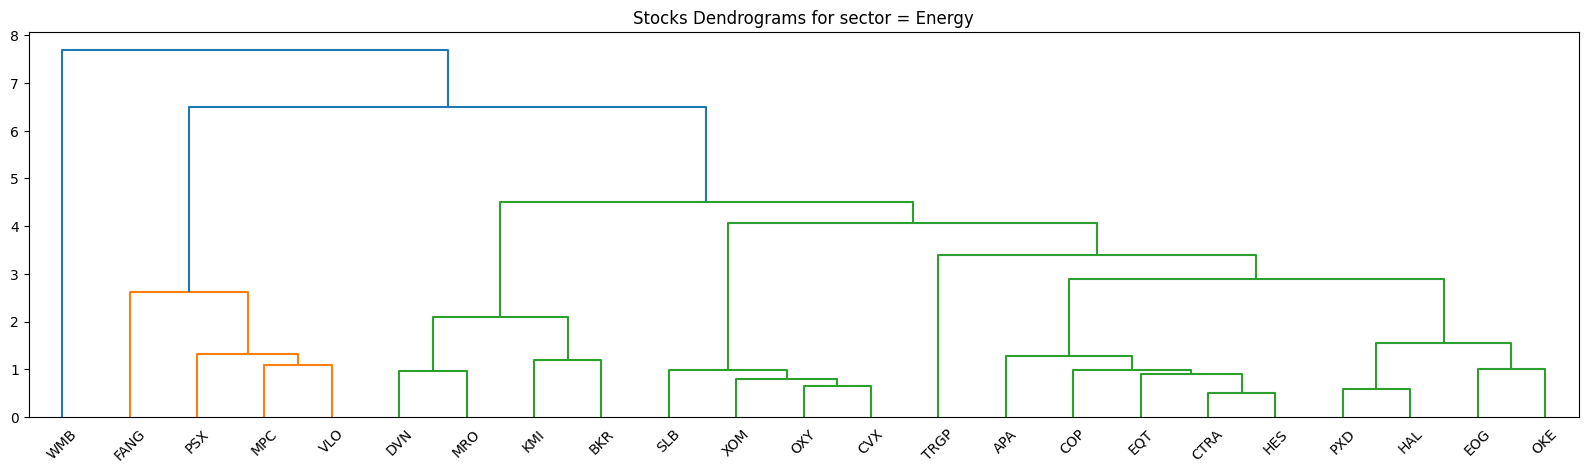

Total number of pairs to check: 7183.0


In [202]:
from scipy.cluster.hierarchy import dendrogram, linkage, ward

Z_sec = {}

for sector in sectors:
    #Calulate linkage
    Z_sec[sector] = linkage(rescaledDataset[sector], method='ward')

total_pairs = 0
num_clusters_dend = {}

for sector in sectors:
    plt.figure(figsize=(20,5))
    plt.title(f"Stocks Dendrograms for sector = {sector}")
    
    dend = dendrogram(Z_sec[sector],labels = rescaledDataset[sector].index)
    counts = Counter(dend['leaves_color_list'])

    num_clusters_dend[sector] = len(counts)
    
    for x in counts.values():
        total_pairs += x*(x-1)*1/2.
    plt.show()
    
print(f'Total number of pairs to check: {total_pairs}')

Total number of pairs to check: 47290.0


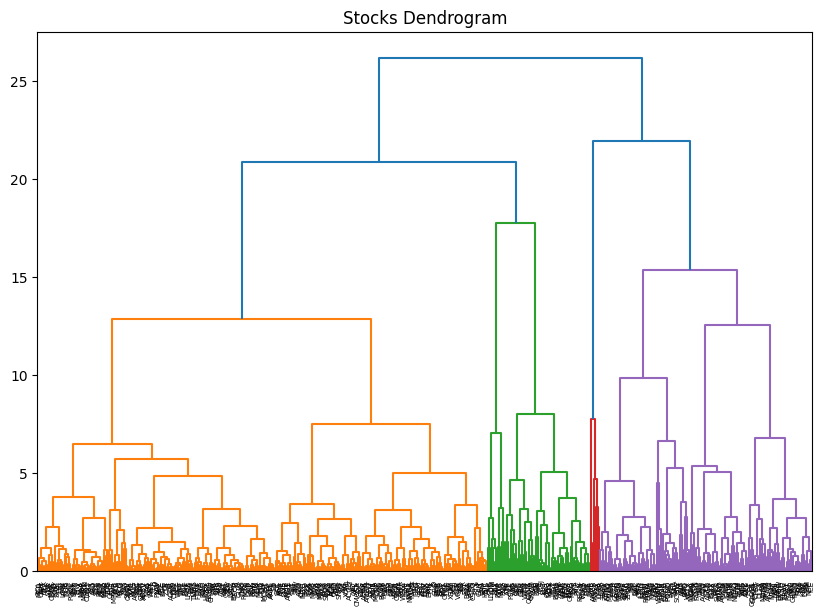

In [155]:
recombined_ds = pd.concat([rescaledDataset[sec] for sec in sectors])
Z_full = linkage(recombined_ds, method='ward')

plt.figure(figsize=(10, 7))
plt.title(f"Stocks Dendrogram")
dend = dendrogram(Z_full,labels = recombined_ds.index)

counts = Counter(dend['leaves_color_list'])
total_pairs = 0

for x in counts.values():
    total_pairs += x*(x-1)*1/2.
print(f'Total number of pairs to check: {total_pairs}')

### Affinity

In [232]:
clust_labels_ap = {}
tot_pairs = 0

for sector in sectors:
    ap = AffinityPropagation()
    ap.fit(rescaledDataset[sector])
    clust_labels_ap[sector] = ap.predict(rescaledDataset[sector])
    
    for x in Counter(clust_labels_ap[sector]).values():
        tot_pairs += x*(x-1)*.5

print(f'Total number of pairs to check: {tot_pairs}')

Total number of pairs to check: 1778.0


In [225]:
tot_pairs=0
for x in Counter(clust_labels_ap['Health Care']).values():
        tot_pairs += x*(x-1)*.5

### Optics

In [355]:
optics_labels = {}
sector_counts = {}

for sector in sectors:
    
    optics_labels[sector] = OPTICS().fit_predict(rescaledDataset[sector])
    sector_counts[sector] = 0
    
    counts = Counter(optics_labels[sector])
    for label, count in counts.items():
        if label == -1:
            continue
        else:
            sector_counts[sector] += count*(count-1)*.5

## Features = [Mean, Volatility]

### K-means

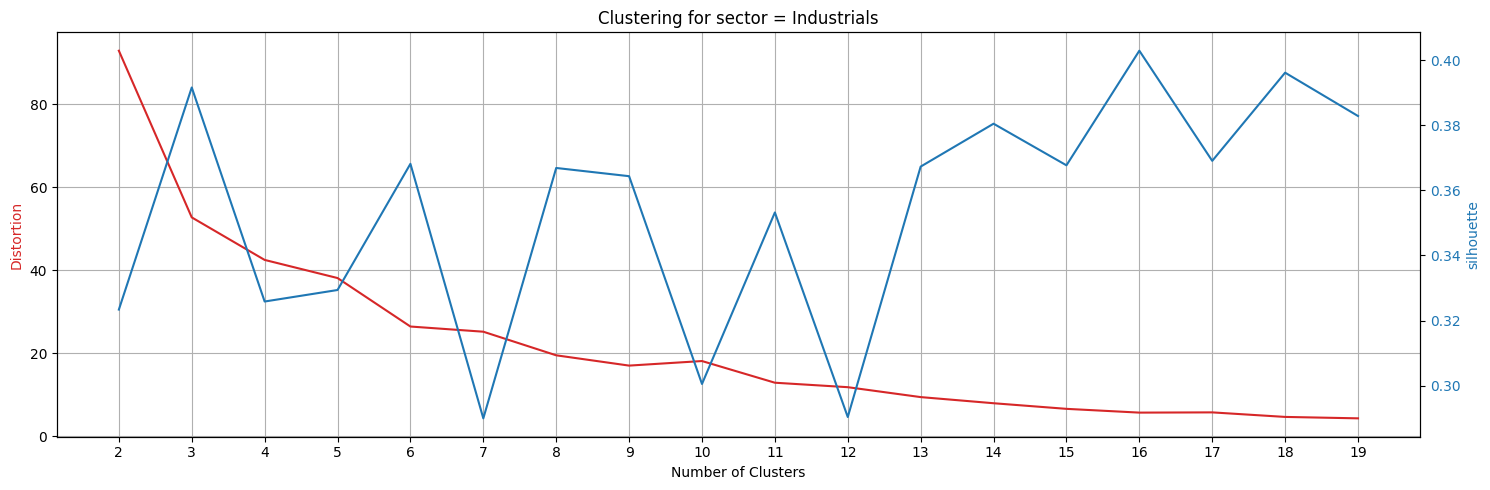

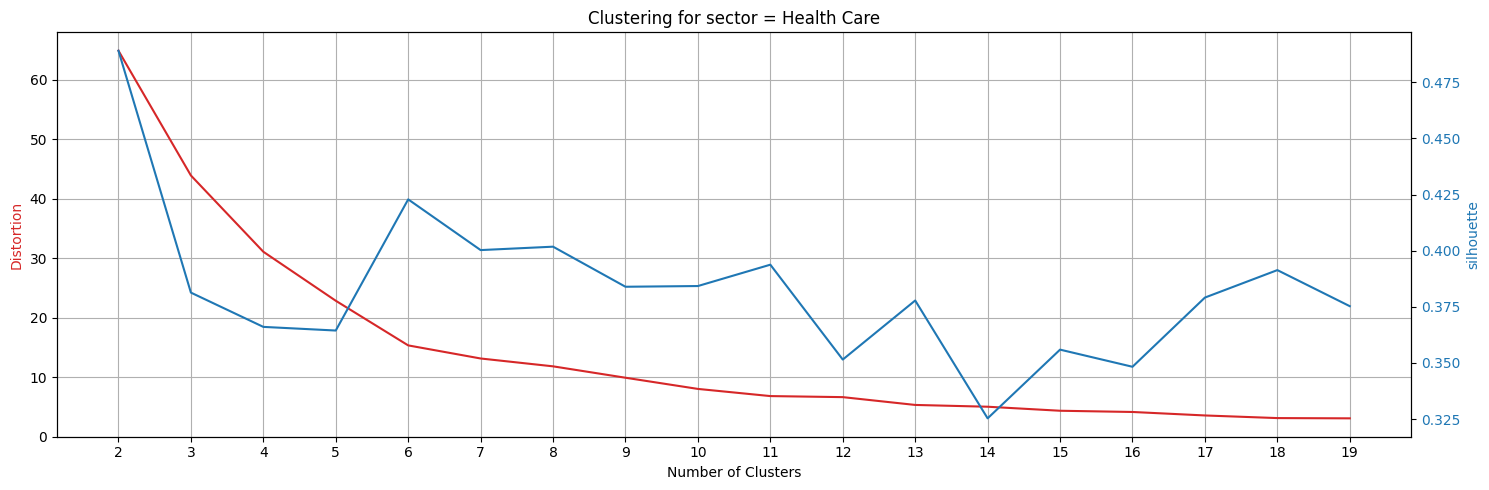

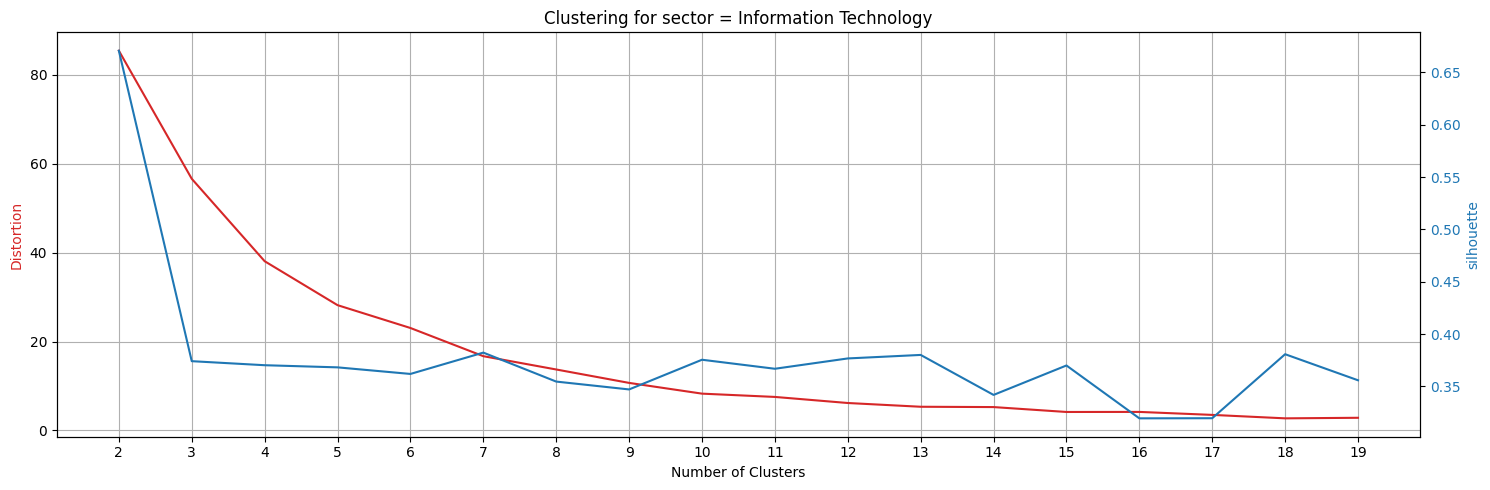

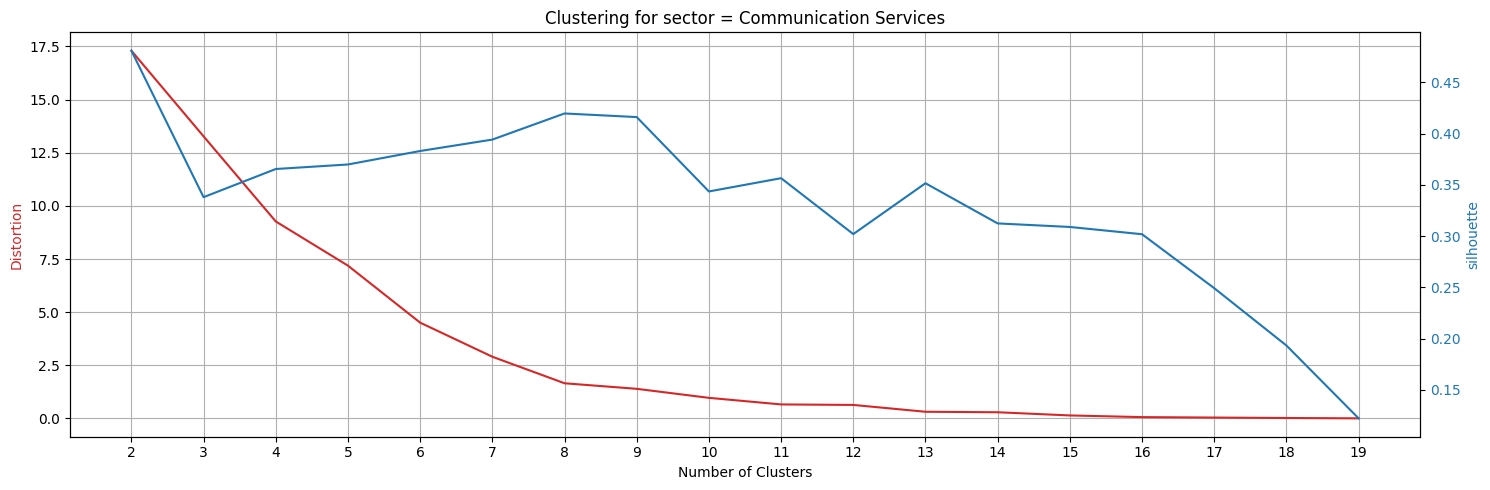

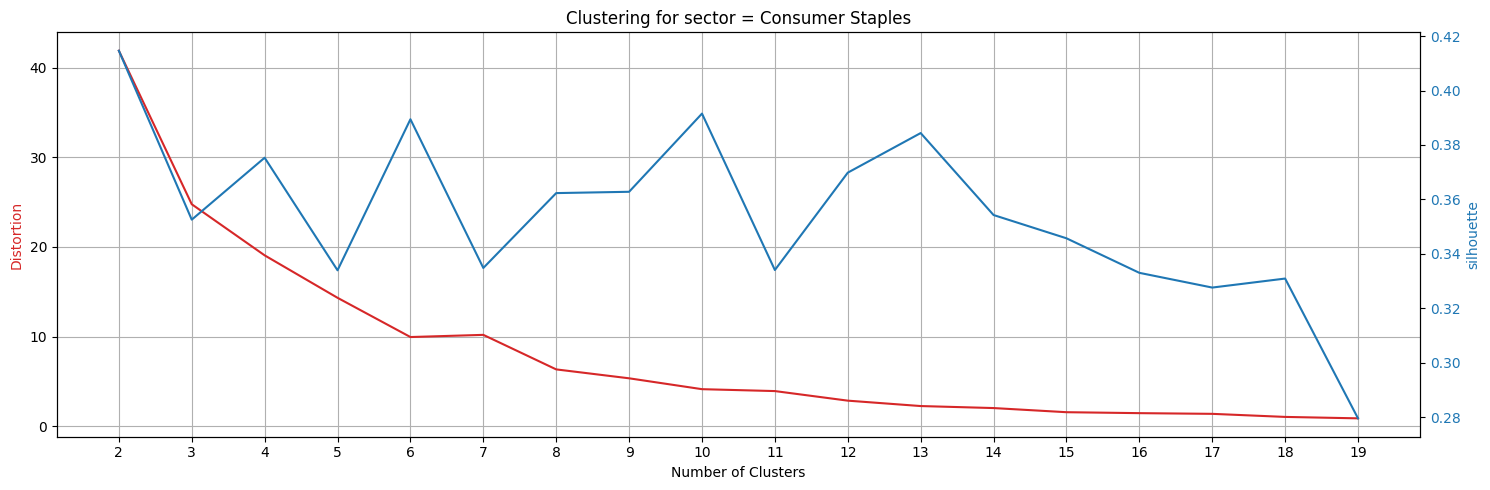

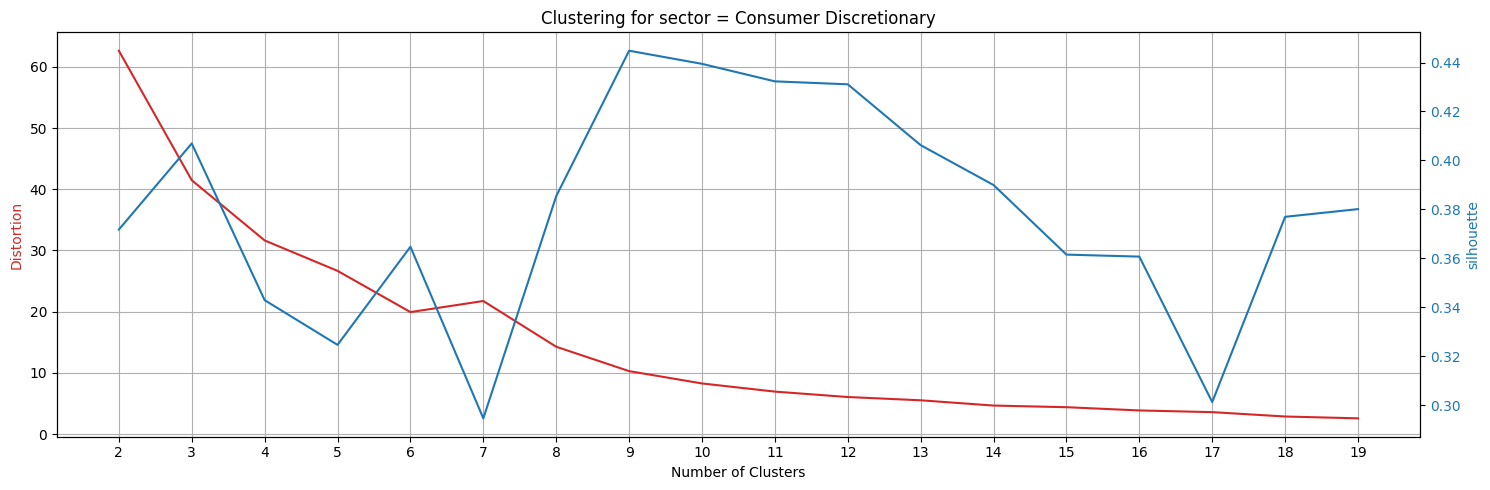

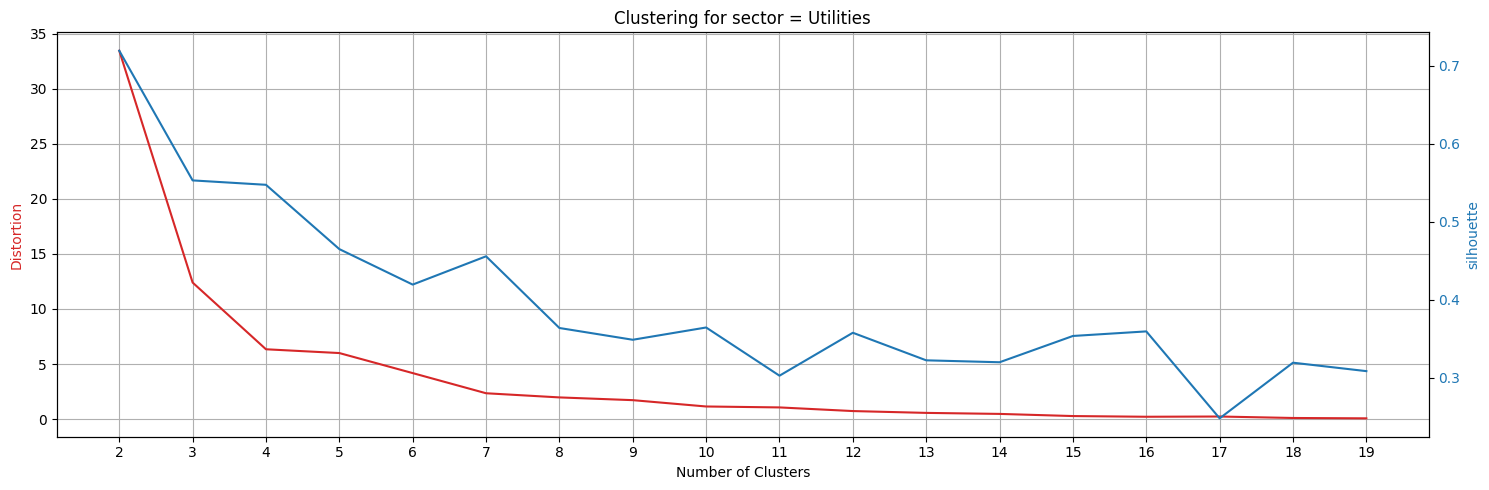

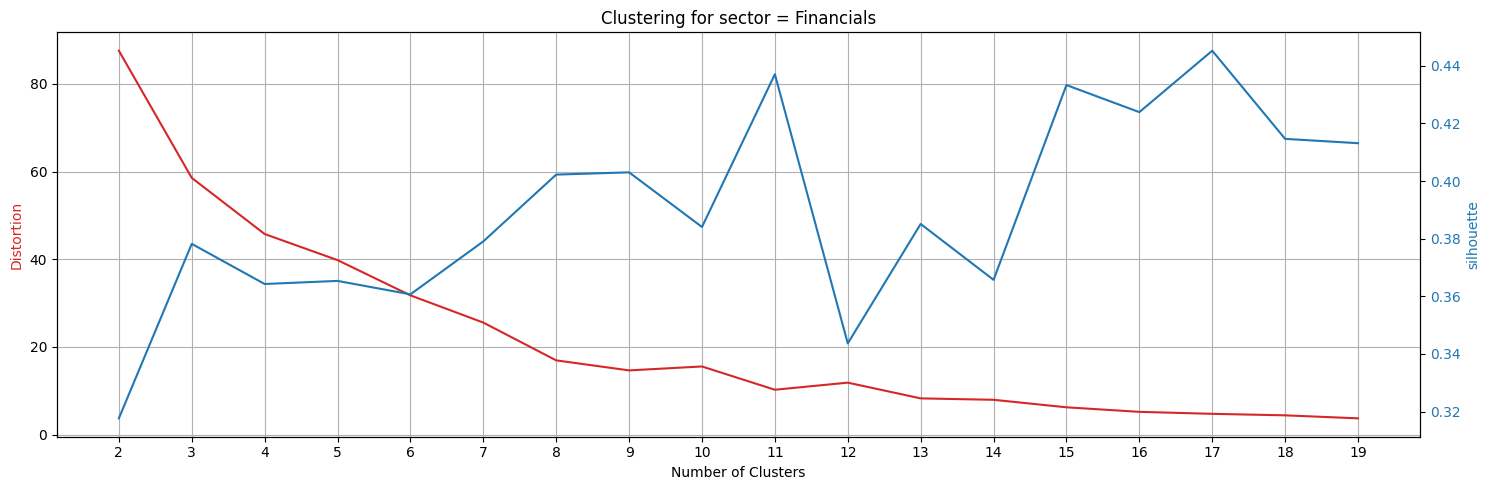

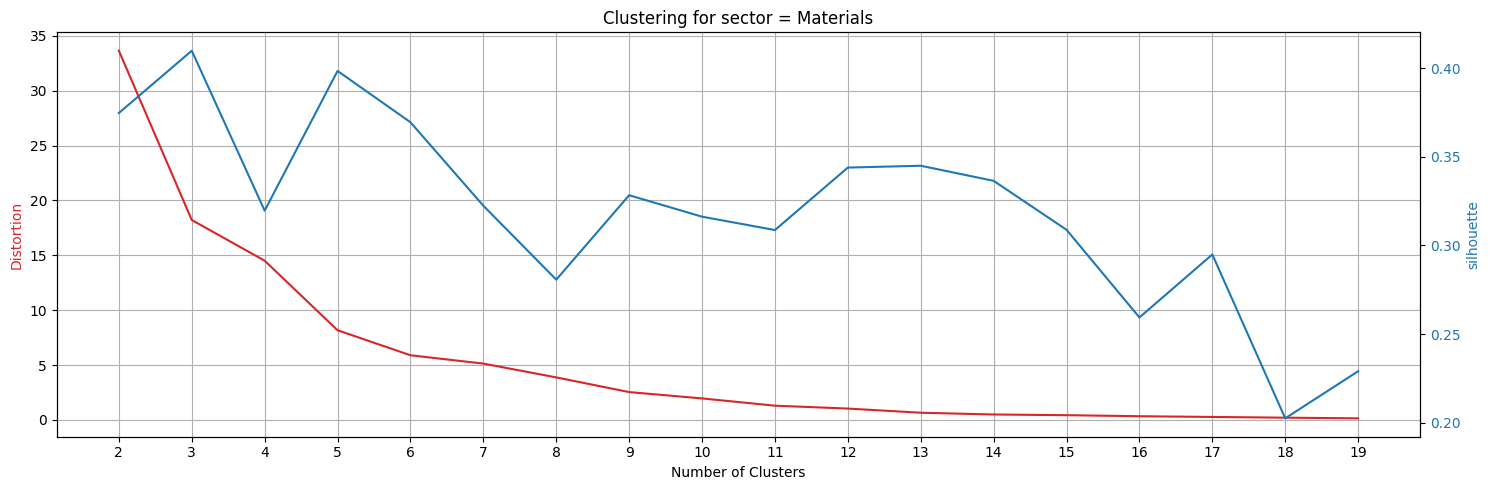

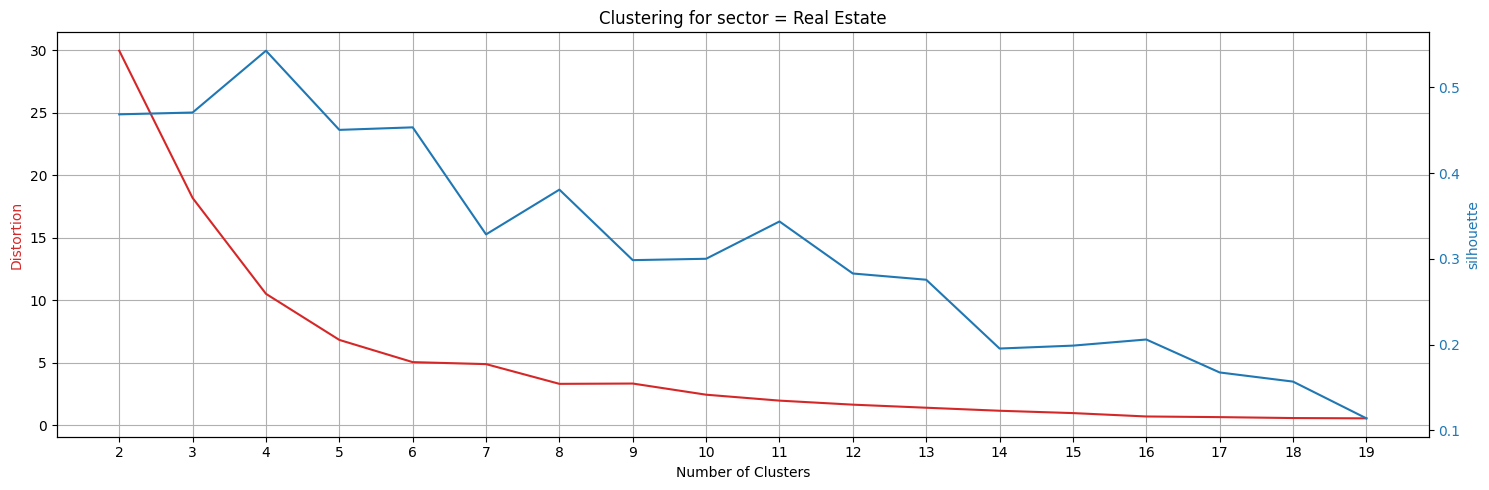

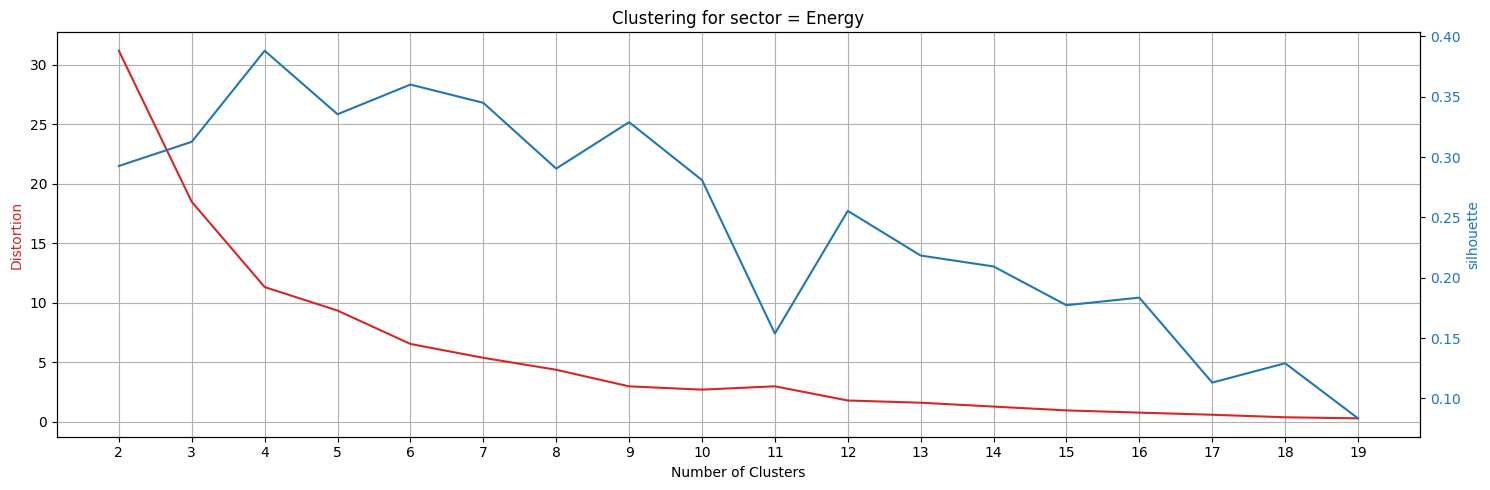

In [209]:
for sector in sectors:
    
    fig, ax1 = plt.subplots(figsize=(15, 5))
    #fig = plt.figure(figsize=(15, 5))
    
    color = 'tab:red'
    ax1.set_xlabel('Number of Clusters')
    ax1.set_ylabel('Distortion',color=color)
    plt.grid(True)
    plt.title(f'Clustering for sector = {sector}')
    distorsions = []
    max_loop=20
    silhouette_score = []
    for k in range(2, max_loop):
        kmeans = KMeans(n_clusters=k,n_init='auto')
        kmeans.fit(rescaledDataset[sector].loc[:,['Returns','Volatility']])
        distorsions.append(kmeans.inertia_)  
        silhouette_score.append(metrics.silhouette_score(rescaledDataset[sector].loc[:,['Returns','Volatility']],
                                                         kmeans.labels_,
                                                         random_state=10))
    ax1.plot(range(2, max_loop), distorsions,color=color)
    ax2 = ax1.twinx()
    
    color='tab:blue'
    ax2.set_ylabel('silhouette',color=color)
    ax2.plot(range(2, max_loop), silhouette_score,color=color)
    ax2.tick_params(axis='y',labelcolor=color)
    
    fig.tight_layout()
    #plt.xticks(ticks=np.arange(2, max_loop))
    plt.xticks([i for i in range(2, max_loop)], rotation=75)
    
    #plt.grid(visible=True, which='both', axis='both');
    
    plt.show()


In [ ]:
for i, sector in enumerate(sectors):
    
    X = rescaledDataset[sector]
    
    k_means = cluster.KMeans(n_clusters = num_clusters_dend[sector],n_init='auto')
    k_means.fit(X)
    target_labels = k_means.predict(X)
    

    centroids = k_means.cluster_centers_
    fig = plt.figure(figsize=(4,10))
    ax = fig.add_subplot(111)
    scatter = ax.scatter(X.iloc[:,0],X.iloc[:,1], c = k_means.labels_, cmap ="rainbow", label = X.index)
    ax.set_title(f'k-Means results for sector = {sector}')
    ax.set_xlabel('Mean Return')
    ax.set_ylabel('Volatility')
    plt.colorbar(scatter)

    plt.plot(centroids[:,0],centroids[:,1],'sg',markersize=11)

In [211]:
num_clusters_dend

{'Industrials': 3,
 'Health Care': 2,
 'Information Technology': 4,
 'Communication Services': 2,
 'Consumer Staples': 3,
 'Consumer Discretionary': 3,
 'Utilities': 3,
 'Financials': 3,
 'Materials': 3,
 'Real Estate': 3,
 'Energy': 3}

### Hierarchical

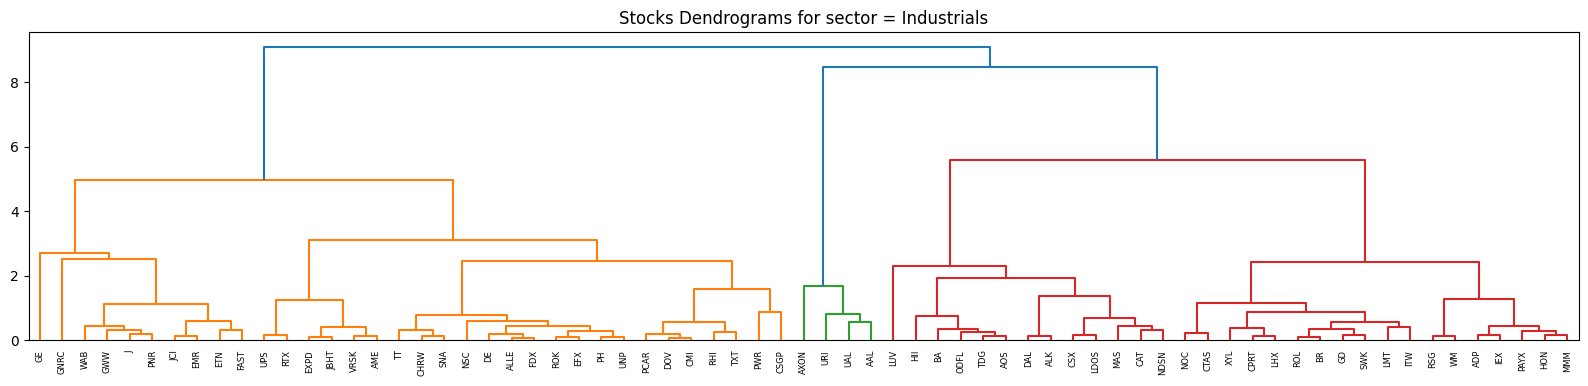

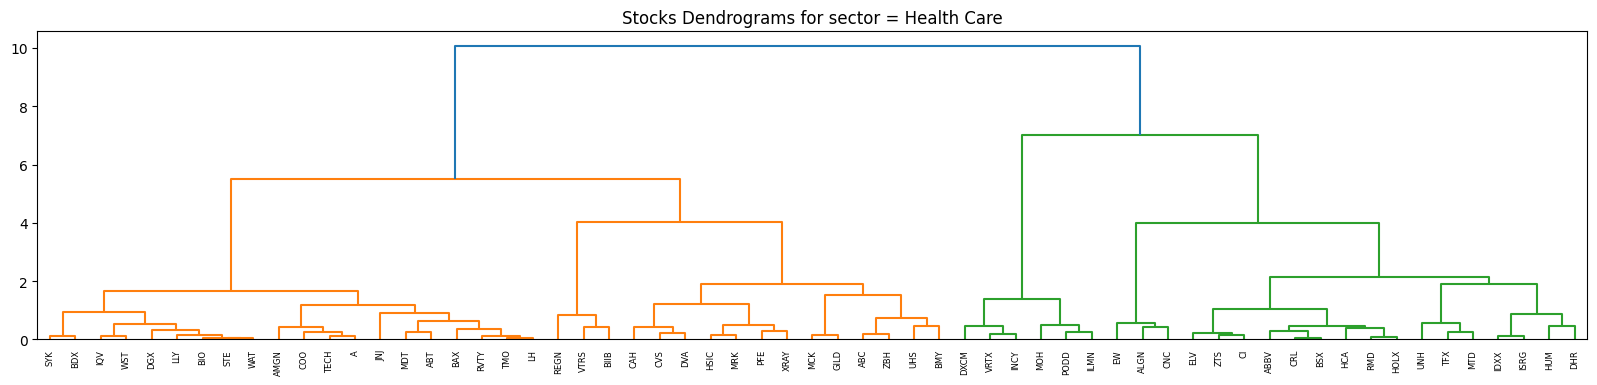

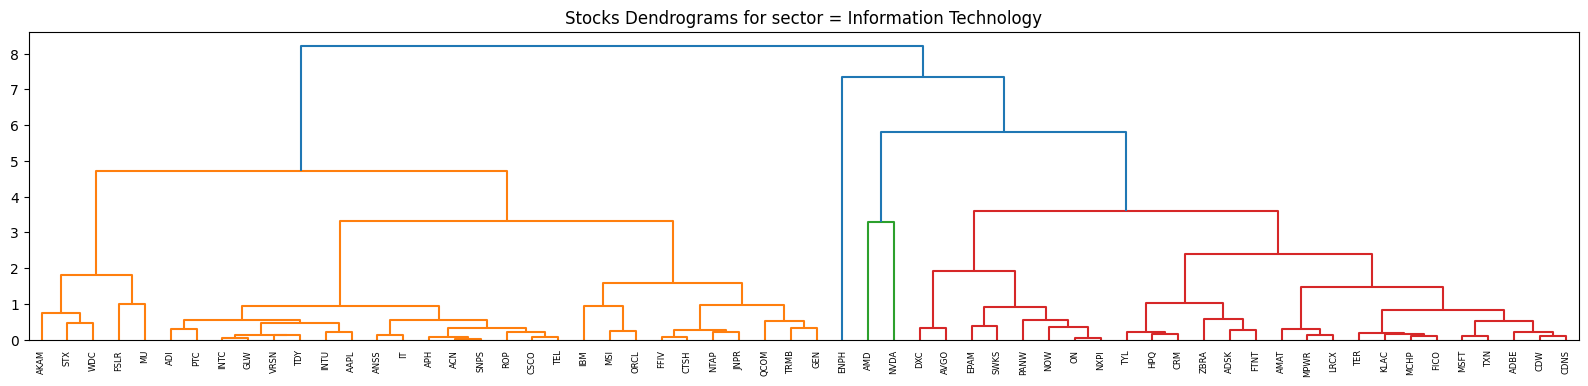

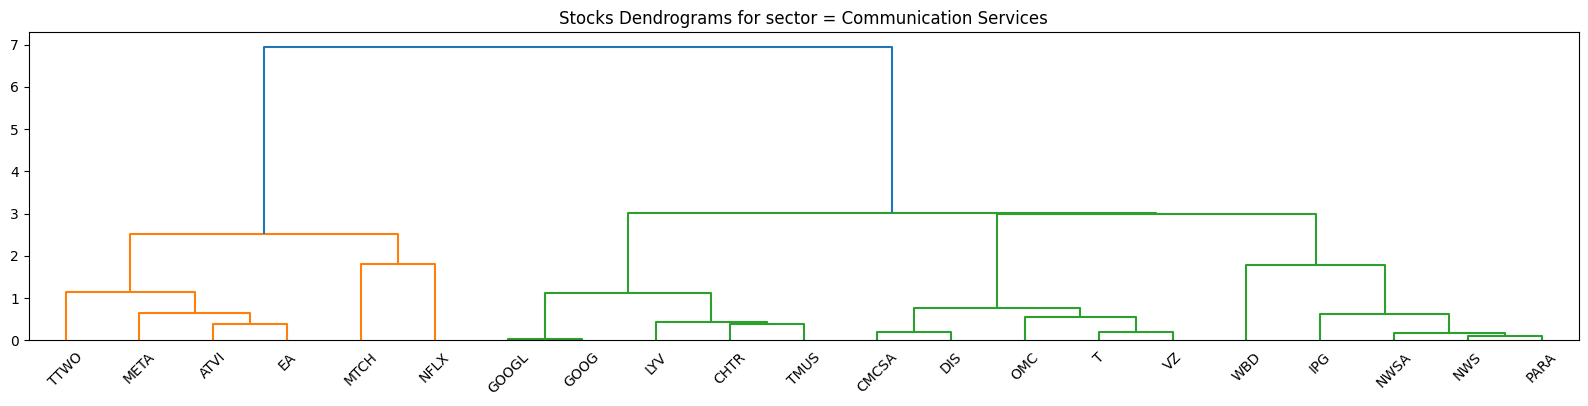

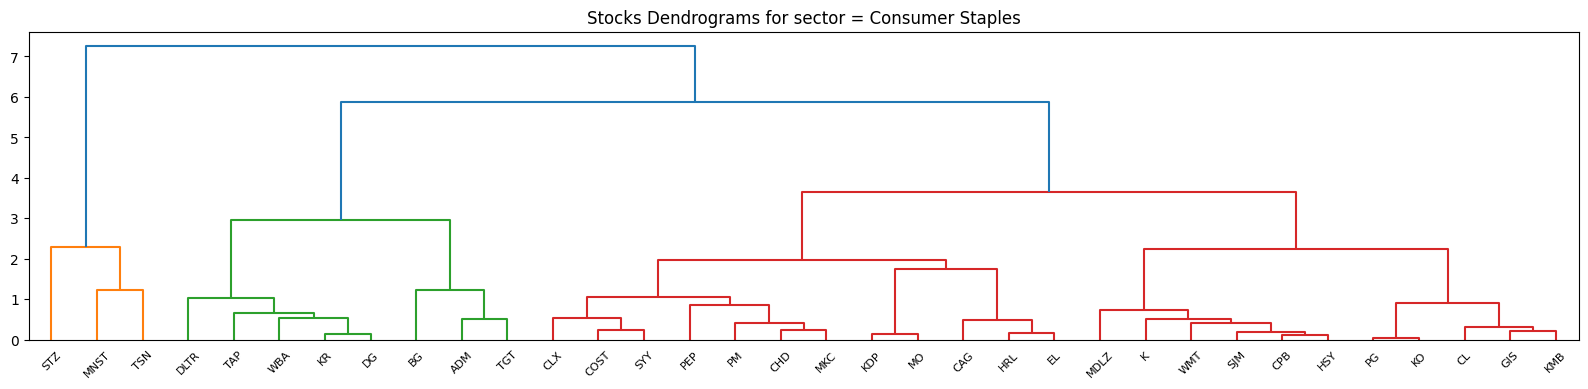

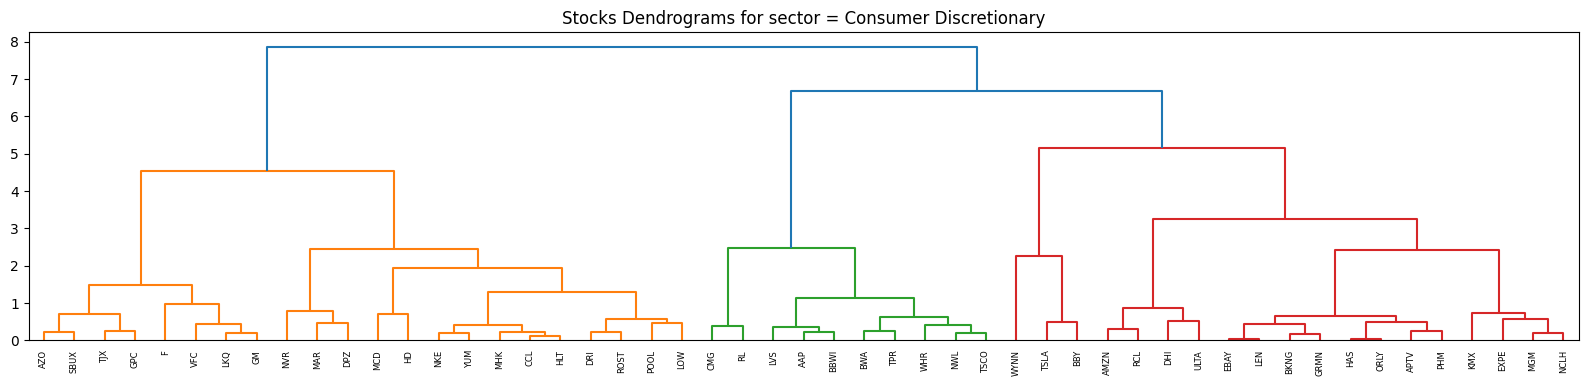

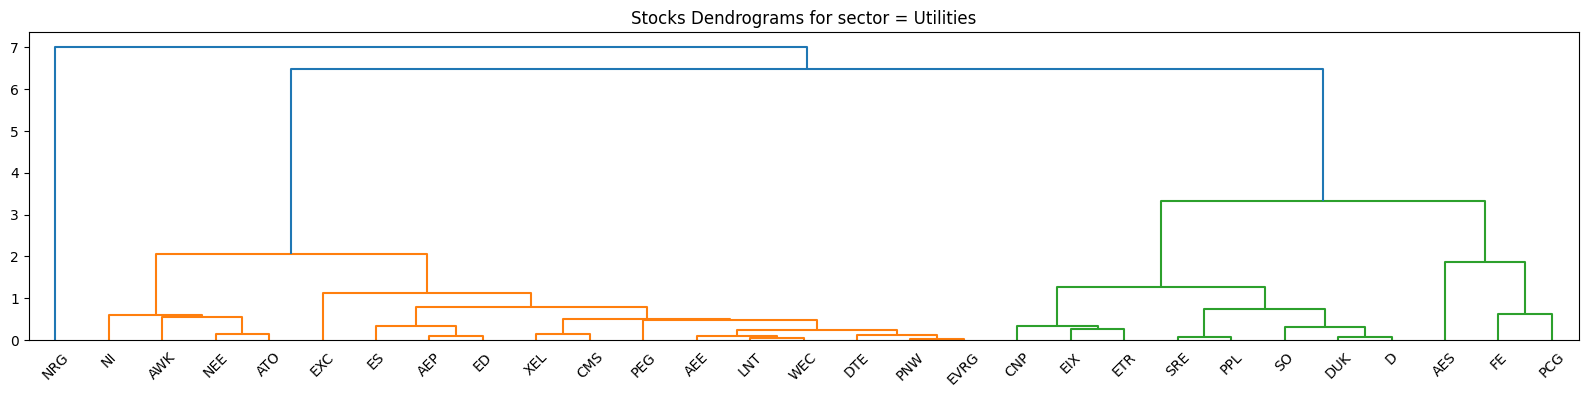

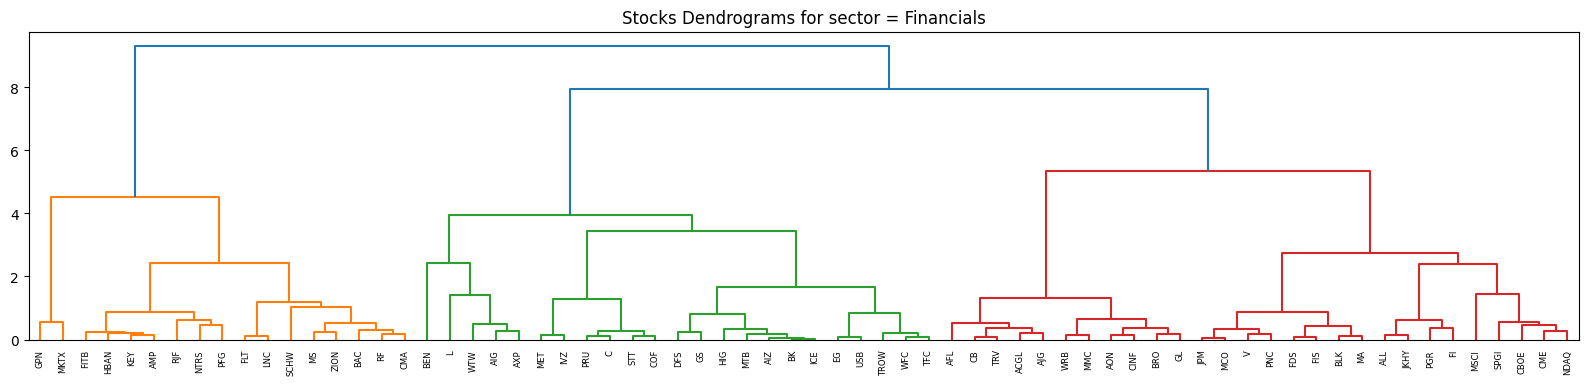

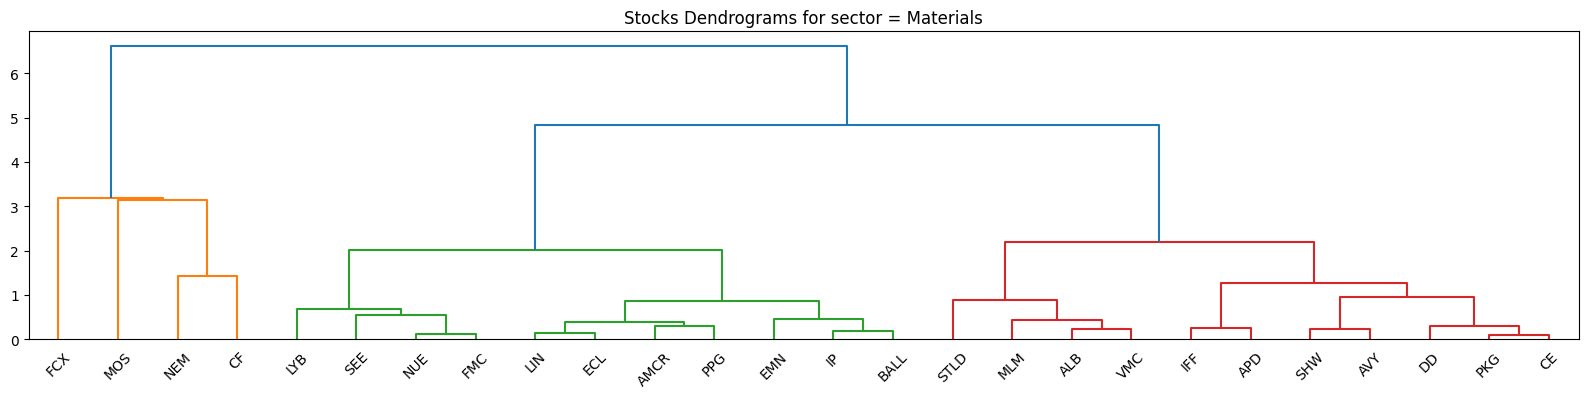

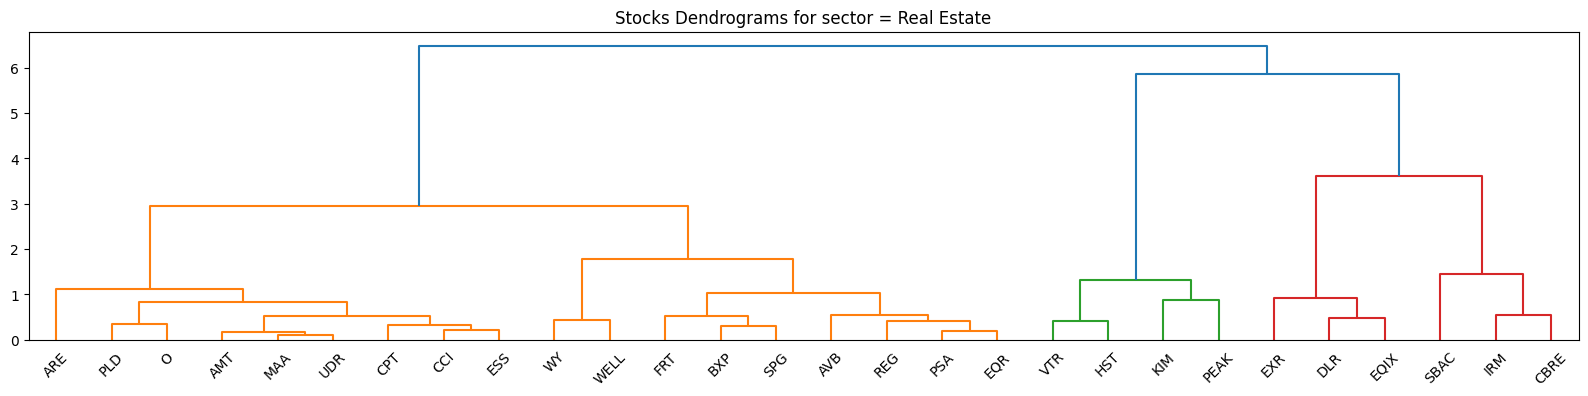

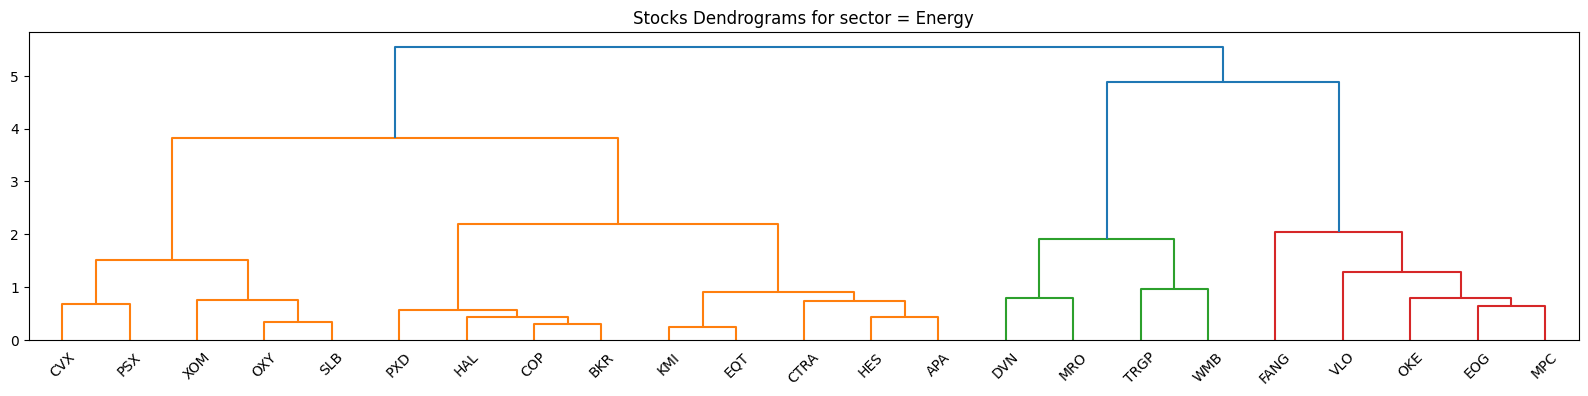

Total number of pairs to check: 4959.0


In [216]:
from scipy.cluster.hierarchy import dendrogram, linkage, ward

Z_sec = {}

for sector in sectors:
    #Calulate linkage
    Z_sec[sector] = linkage(rescaledDataset[sector].loc[:,['Returns','Volatility']], method='ward')

total_pairs = 0
num_clusters_dend = {}

for sector in sectors:
    plt.figure(figsize=(20,4))
    plt.title(f"Stocks Dendrograms for sector = {sector}")
    
    dend = dendrogram(Z_sec[sector],labels = rescaledDataset[sector].index)
    counts = Counter(dend['leaves_color_list'])

    num_clusters_dend[sector] = len(counts)
    
    for x in counts.values():
        total_pairs += x*(x-1)*1/2.
    plt.show()
    
print(f'Total number of pairs to check: {total_pairs}')

### Affinity

Total number of pairs to check: 1839.0


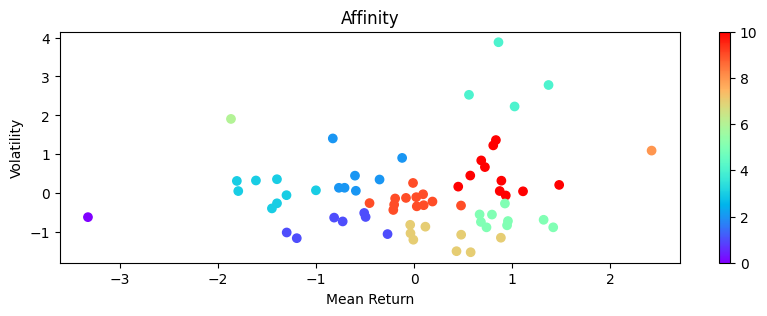

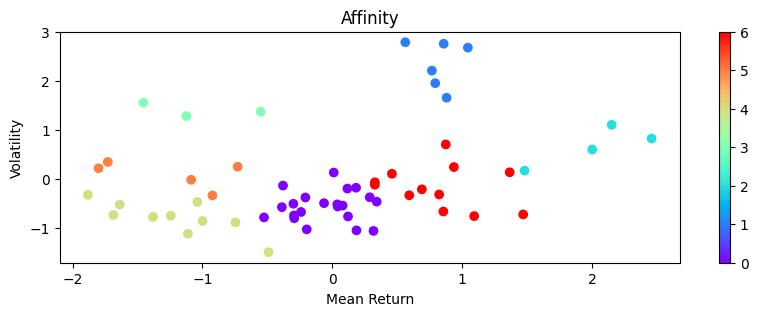

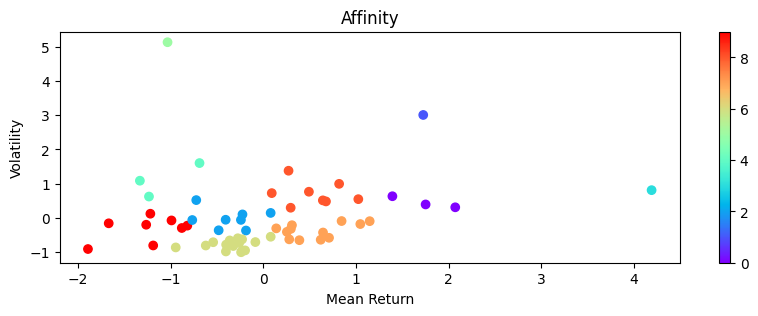

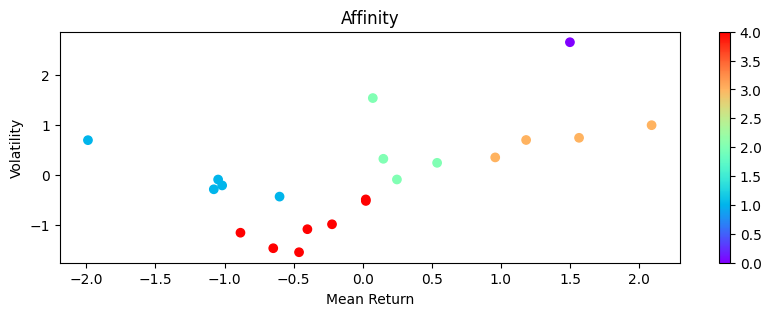

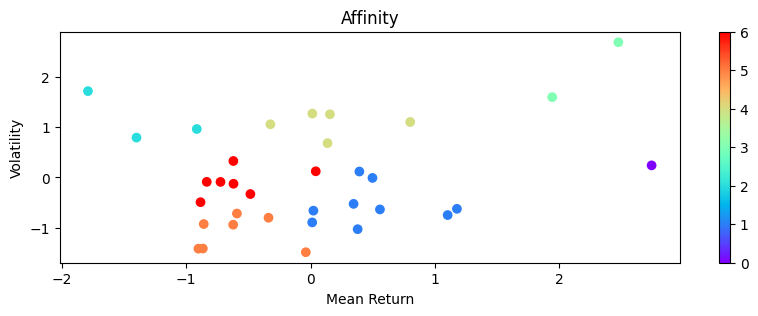

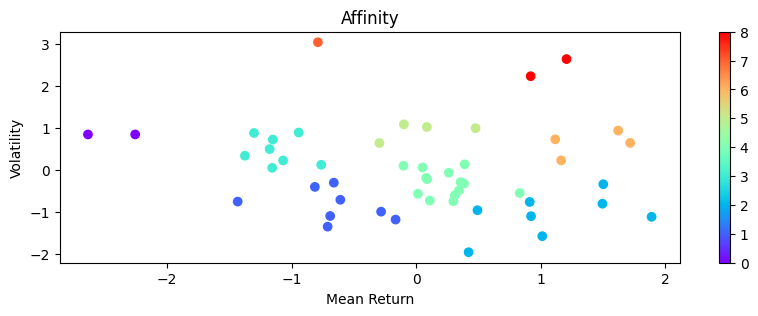

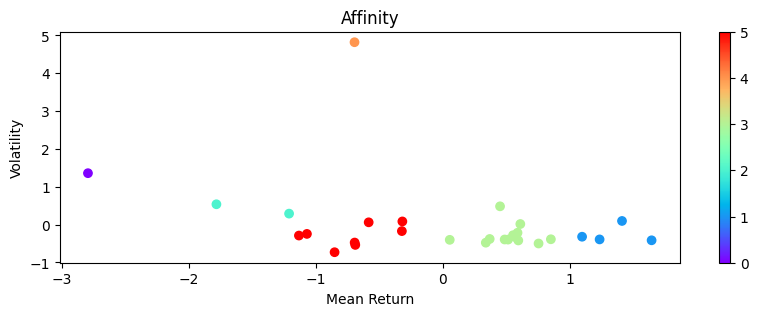

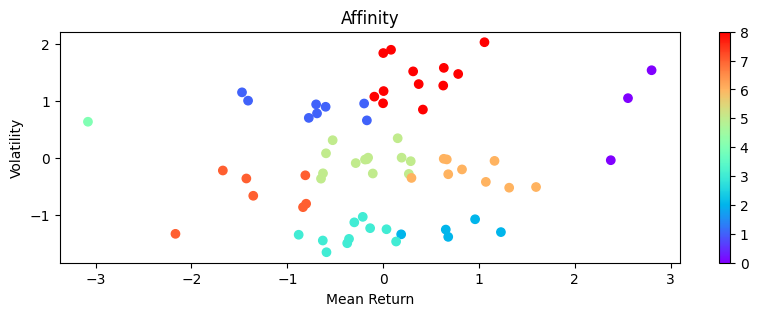

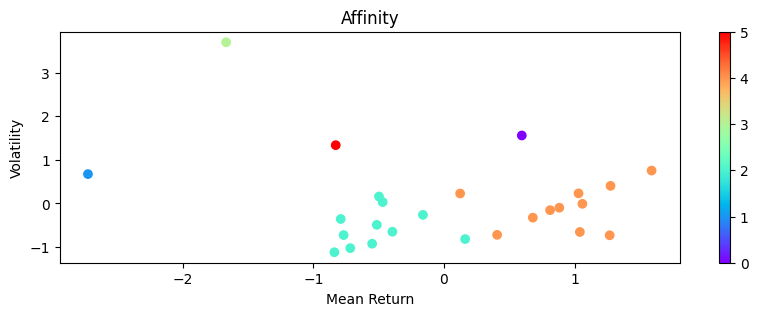

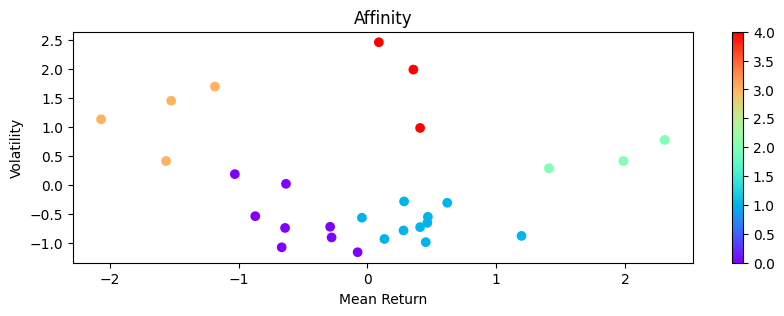

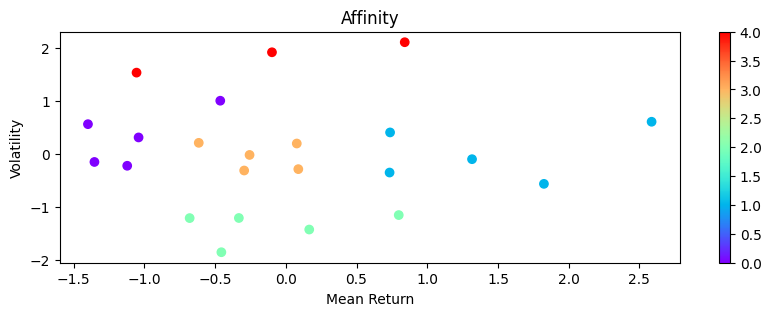

In [219]:
clust_labels_ap = {}
tot_pairs = 0

for sector in sectors:
    ap = AffinityPropagation()
    ap.fit(rescaledDataset[sector].loc[:,['Returns','Volatility']])
    clust_labels_ap[sector] = ap.predict(rescaledDataset[sector].loc[:,['Returns','Volatility']])
    
    for x in Counter(clust_labels_ap[sector]).values():
        tot_pairs += x*(x-1)*.5

print(f'Total number of pairs to check: {tot_pairs}')
        
for sector in sectors:

    fig = plt.figure(figsize=(10,3))
    ax = fig.add_subplot(111)
    scatter = ax.scatter(rescaledDataset[sector].iloc[:,0],rescaledDataset[sector].iloc[:,1], c= clust_labels_ap[sector], cmap ="rainbow")
    ax.set_title('Affinity')
    ax.set_xlabel('Mean Return')
    ax.set_ylabel('Volatility')
    plt.colorbar(scatter)

In [359]:
optics_labels = {}
sector_counts = {}

for sector in sectors:
    X = rescaledDataset[sector].loc[:,['Returns','Volatility']]
    
    optics_labels[sector] = OPTICS().fit_predict(X)
    sector_counts[sector] = 0
    
    counts = Counter(optics_labels[sector])
    for label, count in counts.items():
        if label == -1:
            continue
        else:
            sector_counts[sector] += count*(count-1)*.5
        

In [364]:
np.sum(list(sector_counts.values()))

1550.0

# Pair Trading

In [237]:
clust_labels_ap = {}
tot_pairs = 0

for sector in sectors:
    ap = AffinityPropagation()
    ap.fit(rescaledDataset[sector])
    clust_labels_ap[sector] = ap.predict(rescaledDataset[sector])
    
    for x in Counter(clust_labels_ap[sector]).values():
        tot_pairs += x*(x-1)*.5

print(f'Total number of pairs to check: {tot_pairs}')

Total number of pairs to check: 1778.0


In [242]:
from collections import defaultdict

In [265]:
sector_pairs={}
for sector in sectors:
    sector_pairs[sector] = defaultdict(list)
    for ticker,label in zip(rescaledDataset[sector].index,clust_labels_ap[sector]):
        sector_pairs[sector][label].append(ticker)
    
    for label in clust_labels_ap[sector]:
        if len(sector_pairs[sector][label])<=1:
            del sector_pairs[sector][label]

In [266]:
import itertools

In [274]:
clust_labels_ap[sector]

array([1, 0, 2, 0, 0, 2, 2, 1, 2, 1, 0, 0, 0, 1, 2, 1, 0, 0, 1, 3, 2, 4,
       0])

In [275]:
ct=0
for sector in sectors:
    for label in set(clust_labels_ap[sector]):
        n = len(sector_pairs[sector][label])
        ct+=n*(n-1)*.5
print(ct)

1778.0


In [320]:
ct_dict = {}
for sector in sectors:
    ct=0
    for label in set(clust_labels_ap[sector]):
        n = len(sector_pairs[sector][label])
        ct+=n*(n-1)*.5
    ct_dict[sector] = ct
print(ct_dict)

{'Industrials': 268.0, 'Health Care': 314.0, 'Information Technology': 328.0, 'Communication Services': 37.0, 'Consumer Staples': 101.0, 'Consumer Discretionary': 177.0, 'Utilities': 99.0, 'Financials': 261.0, 'Materials': 56.0, 'Real Estate': 71.0, 'Energy': 66.0}


In [284]:
from tqdm import tqdm

In [365]:
final_pairs = []

for sector in sectors:
    print(sector)
    for label in tqdm(set(clust_labels_ap[sector])):
        pairs_test =  list(itertools.combinations(sector_pairs[sector][label],2))

        for pair in pairs_test:
            stock_1, stock_2 = pair
            result = coint(SP_data[stock_1],SP_data[stock_2])
            score = result[0]
            pvalue = result[1]

            if pvalue <= 0.01:
                final_pairs.append(pair)
print(final_pairs)

Industrials


100%|██████████████████████████████████████████████████████████████████████████████| 13/13 [00:17<00:00,  1.36s/it]


Health Care


100%|████████████████████████████████████████████████████████████████████████████████| 8/8 [00:23<00:00,  2.89s/it]


Information Technology


100%|██████████████████████████████████████████████████████████████████████████████| 11/11 [00:19<00:00,  1.76s/it]


Communication Services


100%|████████████████████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.58it/s]


Consumer Staples


100%|████████████████████████████████████████████████████████████████████████████████| 7/7 [00:07<00:00,  1.10s/it]


Consumer Discretionary


100%|██████████████████████████████████████████████████████████████████████████████| 10/10 [00:11<00:00,  1.13s/it]


Utilities


100%|████████████████████████████████████████████████████████████████████████████████| 6/6 [00:05<00:00,  1.04it/s]


Financials


100%|██████████████████████████████████████████████████████████████████████████████| 11/11 [00:15<00:00,  1.42s/it]


Materials


100%|████████████████████████████████████████████████████████████████████████████████| 7/7 [00:03<00:00,  2.08it/s]


Real Estate


100%|████████████████████████████████████████████████████████████████████████████████| 8/8 [00:04<00:00,  1.90it/s]


Energy


100%|████████████████████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.31it/s]

[('LMT', 'NOC'), ('LMT', 'BR'), ('VRSK', 'PAYX'), ('EXPD', 'HON'), ('EXPD', 'WM'), ('EXPD', 'ADP'), ('WM', 'ADP'), ('TDG', 'MAS'), ('ILMN', 'VRTX'), ('BAX', 'A'), ('TMO', 'WAT'), ('TMO', 'SYK'), ('LH', 'BDX'), ('CAH', 'CVS'), ('INTU', 'APH'), ('ROP', 'ANSS'), ('CDW', 'ADBE'), ('ADBE', 'CDNS'), ('F', 'TJX'), ('EXPE', 'HAS'), ('CMS', 'ED'), ('ES', 'ED'), ('STT', 'C'), ('MET', 'COF'), ('COF', 'GS'), ('RF', 'CMA'), ('RF', 'FITB'), ('RF', 'ZION'), ('HBAN', 'SCHW'), ('FITB', 'ZION'), ('DD', 'CE'), ('CCI', 'CPT')]


In [370]:
!pip install hurst --quiet
from hurst import compute_Hc

In [368]:
SP_data['LMT']/SP_data['NOC']

Date
2014-01-02    1.172209
2014-01-03    1.176517
2014-01-06    1.168014
2014-01-07    1.179261
2014-01-08    1.171432
                ...   
2017-12-22    1.002691
2017-12-26    1.004006
2017-12-27    0.999307
2017-12-28    1.000667
2017-12-29    1.001889
Length: 1007, dtype: float64

In [372]:
compute_Hc((SP_data['LMT']/SP_data['NOC']), kind='price', simplified=True)[0]

0.5363501098476828

In [379]:
pairs_hurst = {}

for pair in final_pairs:
    S1, S2 = pair
    
    H_exp = compute_Hc((SP_data[S1]/SP_data[S2]), kind='price', simplified=True)[0]
    if H_exp<.5:
        pairs_hurst[pair] = H_exp

In [390]:
pairs_hf = []

for pair in pairs_hurst.keys():
    
    S1, S2 = pair
    z_array = (SP_data[S1]/SP_data[S2])
    
    z_lag = np.roll(z_array,1)
    z_lag[0] = 0
    z_ret = z_array - z_lag
    z_ret[0] = 0

    #adds intercept terms to X variable for regression
    z_lag2 = sm.add_constant(z_lag)

    model = sm.OLS(z_ret,z_lag2)
    res = model.fit()

    halflife = -np.log(2) / res.params[1]
    
    if 1 < halflife < 100:
        pairs_hf.append(pair)

In [409]:
pair_pt3 = []

for pair in pairs_hf:
    ct=0
    S1, S2 = pair
    ratio = (SP_data[S1]/SP_data[S2])
    
    ratio = ratio - ratio.mean()
    length = ratio.shape[0]
    
    for i in range(1,length):
        if ratio[i]*ratio[i-1]<0:
            ct+=1
    
    if ct>12*length/252:
        pair_pt3.append(pair)

In [411]:
len(pair_pt3)

18

In [412]:
len(final_pairs)

32